In [1]:
from random import shuffle

import copick
import keras.src.losses
import pandas as pd
import zarr
from dask.array import shape
from matplotlib import pyplot as plt
import os
import json
import numpy as np
from matplotlib import patches
from numba import njit, prange
from scipy.spatial import cKDTree
from collections import defaultdict
from tqdm import tqdm
import tensorflow as tf
from keras import layers, Model
from typing import List, Dict
import gc

In [2]:
def get_copick_root(split):
    """
    Loads the copick configuration based on the split.

    Args:
        split (str): 'train' or 'test'.

    Returns:
        copick_root: The loaded copick configuration.
    """
    config_path = '../../../copick_config.json' if split == 'train' else '../../../copick_config_test.json'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")
    copick_root = copick.from_file(config_path)
    return copick_root


In [3]:
def get_static_tomogram(run_name, split='train', tomo_type='denoised', zarr_group_idx=0):
    """
    Retrieves a static tomogram from the copick dataset.

    Args:
        run_name (str): Name of the run.
        split (str): 'train' or 'test'.
        tomo_type (str): Type of tomogram.
        zarr_group_idx (int): Index of the Zarr group.

    Returns:
        np.ndarray: The tomogram data as a NumPy array.
    """
    copick_root = get_copick_root(split)
    run = copick_root.get_run(run_name)
    voxel_spacing = run.get_voxel_spacing(10.000)
    tomogram = voxel_spacing.get_tomogram(tomo_type)
    zarr_store = tomogram.zarr()
    zarr_group = zarr.open(zarr_store, mode='r')
    try:
        tomogram_vals = zarr_group[str(zarr_group_idx)][:]  # Use string keys if necessary
    except KeyError:
        raise KeyError(f"Zarr group index {zarr_group_idx} not found in the store.")
    return tomogram_vals


In [4]:
# Load copick configurations
copick_root_train = get_copick_root('train')
copick_root_test = get_copick_root('test')

In [5]:
# Retrieve run names
training_runs = copick_root_train.runs
testing_runs = copick_root_test.runs

training_run_names = [run.name for run in training_runs]
testing_run_names = [run.name for run in testing_runs]
extra_training_run_names = list(set(training_run_names) - set(testing_run_names))

print(f'Training runs: {training_run_names}')
print(f'Testing runs: {testing_run_names}')
print(f'Extra training runs not in testing: {extra_training_run_names}')


Training runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
Testing runs: ['TS_5_4', 'TS_69_2', 'TS_6_4']
Extra training runs not in testing: ['TS_86_3', 'TS_73_6', 'TS_99_9', 'TS_6_6']


In [6]:
# Load tomograms
tomograms_train = []
tomograms_test = []

for training_run_name in training_run_names[:1]:
    try:
        tomo = get_static_tomogram(split='train', run_name=training_run_name)
        tomograms_train.append({'run': training_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {training_run_name}: {e}")

for testing_run_name in testing_run_names:
    try:
        tomo = get_static_tomogram(split='test', run_name=testing_run_name)
        tomograms_test.append({'run': testing_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {testing_run_name}: {e}")


print(f'Number of train tomograms: {len(tomograms_train)}')
print(f'Number of test tomograms: {len(tomograms_test)}')


Number of train tomograms: 1
Number of test tomograms: 3


In [7]:
# Verify the loaded tomograms
if tomograms_train:
    sample_tomo = tomograms_train[0]['tomogram']
    print(f"Type: {type(sample_tomo)}")
    print(f"Element Type: {type(sample_tomo[0])}")
    print(f"Shape: {sample_tomo.shape}")
else:
    print("No training tomograms loaded.")


Type: <class 'numpy.ndarray'>
Element Type: <class 'numpy.ndarray'>
Shape: (184, 630, 630)


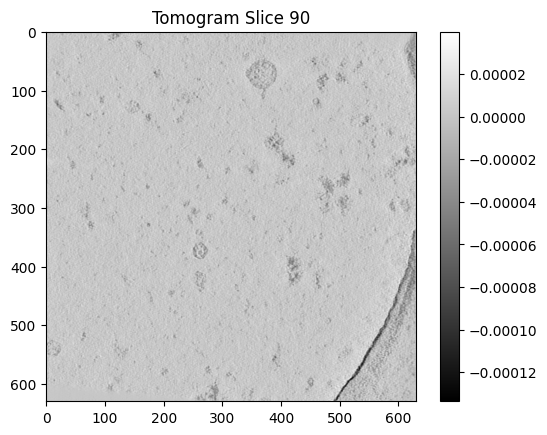

In [8]:
# Visualize a slice
if tomograms_train:
    slice_index = 90  # Adjust as needed
    if slice_index < tomograms_train[0]['tomogram'].shape[0]:
        plt.imshow(tomograms_train[0]['tomogram'][slice_index], cmap='gray')
        plt.title(f"Tomogram Slice {slice_index}")
        plt.colorbar()
        plt.show()
    else:
        print(
            f"Slice index {slice_index} out of range for tomogram with depth {tomograms_train[0]['tomogram'].shape[0]}")
else:
    print("No training tomograms to visualize.")


In [9]:
def get_label_locations(run_name, copick_root, voxel_spacing=10):
    """
    Extracts label locations from JSON files for a given run.

    Args:
        run_name (str): Name of the run.
        copick_root: Copick root object.
        voxel_spacing (float): Voxel spacing for normalization.

    Returns:
        dict: Dictionary with particle names as keys and arrays of locations as values.
    """
    picks_folder = os.path.join(copick_root.config.overlay_root, 'ExperimentRuns', run_name, 'Picks')
    if not os.path.exists(picks_folder):
        raise FileNotFoundError(f"Picks folder not found: {picks_folder}")

    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            particle_name = json_file[:-5]  # Remove '.json' extension
            picks[particle_name] = np.array([
                [
                    point['location']['x'] / voxel_spacing,
                    point['location']['y'] / voxel_spacing,
                    point['location']['z'] / voxel_spacing
                ]
                for point in pick_data.get('points', [])
            ])
    return picks

def get_particle_locations(run_name):
    # Create DataFrame with particle locations
    rows = []
    
    label_data = get_label_locations(run_name, copick_root_train)
    for particle, locations in label_data.items():
        matching_particles = [obj.radius for obj in copick_root_train.config.pickable_objects if obj.name == particle]
        if not matching_particles:
            print(f"No matching particle found for {particle} in run {run}")
            continue
        radius = matching_particles[0] / 10
        for location in locations:
            rows.append({
                'particle': particle,
                'x': location[0],
                'y': location[1],
                'z': location[2],
                'radius': radius
            })
    
    particle_locations_df = pd.DataFrame(rows)
    
    return particle_locations_df

for run in training_run_names:
    particle_locations = get_particle_locations(run)
    for tomo in tomograms_train:
        if tomo['run'] == run:
            tomo['particle_locations']=particle_locations

print(f"Total labeled particles in {tomograms_train[0]['run']}: {len(tomograms_train[0]['particle_locations'])}")
print(f'Sample of particle location in {tomograms_train[0]['run']}:')
print(tomograms_train[0]['particle_locations'].sample(5))

Total labeled particles in TS_5_4: 140
Sample of particle location in TS_5_4:
          particle         x         y         z  radius
123  thyroglobulin  227.3228  149.2983   94.9712    13.0
11        ribosome  472.5193  409.0105  111.0456    15.0
98    apo-ferritin  465.7210  513.0873   98.9265     6.0
132  thyroglobulin  291.7805  395.8293   73.0732    13.0
122  thyroglobulin  309.5628  584.3591   94.7596    13.0


In [10]:
unique_particles=pd.DataFrame()
for tomo in tomograms_train:
    unique_particles = pd.concat([unique_particles,tomo['particle_locations'][['particle','radius']].drop_duplicates()],axis=0,ignore_index=True)
unique_particles=unique_particles.drop_duplicates()

particle_types = sorted(unique_particles['particle'].unique())

particle_sizes = {}
for i in unique_particles.to_dict(orient='records'):
    particle_sizes[i['particle']] = i['radius']

# Print the unique particle types and their radii
print("Unique Particle Types and Their Radii:")
print(unique_particles.sort_values(by='radius', ascending=False).reset_index(drop=True))

Unique Particle Types and Their Radii:
              particle  radius
0             ribosome    15.0
1  virus-like-particle    13.5
2        thyroglobulin    13.0
3   beta-galactosidase     9.0
4         beta-amylase     6.5
5         apo-ferritin     6.0


In [11]:
def compute_ground_truth_boxes(df):
    """
    Computes ground truth bounding boxes from particle center points and radii.

    Args:
        df (pd.DataFrame): DataFrame with columns ['run', 'particle', 'x', 'y', 'z', 'radius'].

    Returns:
        np.ndarray: Array of ground truth boxes with shape (N, 6), where each box is (x_min, y_min, z_min, x_max, y_max, z_max).
        np.ndarray: Array of corresponding particle labels (strings).
    """
    # Compute the min and max bounds for each box
    x_min = df['x'] - df['radius']
    x_max = df['x'] + df['radius']
    y_min = df['y'] - df['radius']
    y_max = df['y'] + df['radius']
    z_min = df['z'] - df['radius']
    z_max = df['z'] + df['radius']
    
    # Combine min and max bounds into a single array
    ground_truth_boxes = np.stack([x_min, y_min, z_min, x_max, y_max, z_max], axis=1)
    
    ground_truth_indices = list(range(len(ground_truth_boxes)))
    
   
    # Create a mapping of particle labels to integer IDs
    unique_labels = df['particle'].unique()
    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    id_to_label = {idx:label for label,idx in label_to_id.items()}
    
    # Encode particle labels as integers
    encoded_labels = df['particle'].map(label_to_id).values
    
    return ground_truth_indices, ground_truth_boxes, encoded_labels, label_to_id,id_to_label

for tomo in tomograms_train:
    tomo['ground_truth_indices'],tomo['ground_truth_boxes'],tomo['ground_truth_labels'],tomo['label_to_id'],tomo['id_to_label'] = compute_ground_truth_boxes(tomo['particle_locations'])

    print(f'Number of ground truth boxes in run {tomo['run']}: {len(tomo['ground_truth_boxes'])}')

gt_sizes = tomograms_train[0]['ground_truth_boxes'][:,4]-tomograms_train[0]['ground_truth_boxes'][:,1]
unique_gt_sizes = np.unique(gt_sizes)
print('Unique ground truth box radii:')
print(np.unique([round(i,4)/2 for i in unique_gt_sizes]))
print('Unique ground truth box diameters:')
print(np.unique([round(i,4) for i in unique_gt_sizes]))

del gt_sizes
del unique_gt_sizes

Number of ground truth boxes in run TS_5_4: 140
Unique ground truth box radii:
[ 6.   6.5  9.  13.  13.5 15. ]
Unique ground truth box diameters:
[12. 13. 18. 26. 27. 30.]


In [12]:
for tomo in tomograms_train:
    # Prepare tomogram for model input
    tomo['tomogram_with_channel'] = np.expand_dims(tomo['tomogram'], axis=-1)  # Add channel dimension
    
print(f"Tomogram Shape: {tomograms_train[0]['tomogram'].shape}")
print(f'Tomogram With Channel Shape: {tomograms_train[0]['tomogram_with_channel'].shape}')

Tomogram Shape: (184, 630, 630)
Tomogram With Channel Shape: (184, 630, 630, 1)


In [13]:
def build_backbone(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    
    # Backbone
    x = layers.Conv3D(16,(3,3,3),activation='relu',padding='same')(inputs)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    x = layers.Conv3D(32,(3,3,3),activation='relu',padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    
    model = keras.Model(inputs=inputs, outputs=x,name='backbone')

    return model

def calculate_cumulative_stride(backbone_model):
    """
    Calculates the cumulative stride of the backbone CNN by traversing its layers.
    
    Args:
        backbone_model (keras.Model): The backbone CNN model.
    
    Returns:
        tuple: Cumulative strides along (z, y, x).
    """
    stride_z, stride_y, stride_x = 1, 1, 1
    for layer in backbone_model.layers:
        if isinstance(layer, layers.MaxPooling3D):
            pool_size = layer.pool_size  # e.g., (2, 2, 2)
            strides = layer.strides      # e.g., (2, 2, 2)
            stride_z *= strides[0]
            stride_y *= strides[1]
            stride_x *= strides[2]
    return stride_z, stride_y, stride_x

backbone = build_backbone(tomograms_train[0]['tomogram_with_channel'].shape)
feature_map = backbone.output
print(f'Input Tomogram Shape: {tomograms_train[0]['tomogram_with_channel'].shape}')
print(f'Feature Map Shape: {feature_map.shape}')

# Calculate 
stride_z, stride_y, stride_x = calculate_cumulative_stride(backbone)
print(f"Cumulative Strides - Z: {stride_z}, Y: {stride_y}, X: {stride_x}")

scales=sorted(np.array(list(particle_sizes.values()))/stride_z*2)
print(f'Anchor box generation scales: {[str(i) for i in scales]}')

aspect_ratios = [(1, 1, 1)]
print(f'Anchor box generation aspect ratios: {aspect_ratios}')
boxes_per_anchors = len(scales) * len(aspect_ratios)

Input Tomogram Shape: (184, 630, 630, 1)
Feature Map Shape: (None, 46, 158, 158, 32)
Cumulative Strides - Z: 4, Y: 4, X: 4
Anchor box generation scales: ['3.0', '3.25', '4.5', '6.5', '6.75', '7.5']
Anchor box generation aspect ratios: [(1, 1, 1)]


In [14]:
def create_anchors(feature_map_shape, scales, aspect_ratios):
    """
    Generates and clips anchor boxes based on the feature map and anchor parameters.

    Args:
        feature_map_shape (tuple): Shape of the feature map (batch_size, D, H, W, C).
        voxel_spacing (float): Voxel spacing used in the tomogram.
        scales (list): List of scales.
        aspect_ratios (list of tuples): List of aspect ratios (w, h, d).

    Returns:
        np.ndarray: Array of clipped anchor boxes with shape (N, 6).
    """
    D, H, W = feature_map_shape[1], feature_map_shape[2], feature_map_shape[3]
    # Define centers based on voxel spacing and feature map stride
    centers_z = np.arange(D)
    centers_y = np.arange(H)
    centers_x = np.arange(W)
    anchor_boxes,anchor_centres = generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios)
    anchor_boxes = clip_boxes(anchor_boxes, feature_map_shape)
    return anchor_boxes,anchor_centres

def clip_boxes(anchor_boxes, input_shape):
    """
    Clips anchor boxes to lie within the input volume.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes with shape (N, 6).
        input_shape (tuple): Shape of the input volume (D, H, W, C).

    Returns:
        np.ndarray: Clipped anchor boxes.
    """
    D_max, H_max, W_max = input_shape[1], input_shape[2], input_shape[3]
    # Clipping
    anchor_boxes[:, 0] = np.clip(anchor_boxes[:, 0], 0, W_max - 1)  # x_min
    anchor_boxes[:, 1] = np.clip(anchor_boxes[:, 1], 0, H_max - 1)  # y_min
    anchor_boxes[:, 2] = np.clip(anchor_boxes[:, 2], 0, D_max - 1)  # z_min
    anchor_boxes[:, 3] = np.clip(anchor_boxes[:, 3], 0, W_max - 1)  # x_max
    anchor_boxes[:, 4] = np.clip(anchor_boxes[:, 4], 0, H_max - 1)  # y_max
    anchor_boxes[:, 5] = np.clip(anchor_boxes[:, 5], 0, D_max - 1)  # z_max
    return anchor_boxes

def generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios, stride=4):
    """
    Efficiently generates anchor boxes using numpy broadcasting with correct shape alignment.
    
    Args:
        centers_z (np.ndarray): Array of center z-coordinates, shape (Nz,)
        centers_y (np.ndarray): Array of center y-coordinates, shape (Ny,)
        centers_x (np.ndarray): Array of center x-coordinates, shape (Nx,)
        scales (list): List of scales, length S
        aspect_ratios (list of tuples): List of aspect ratios (w_ratio, h_ratio, d_ratio), length R
        stride (int): Stride factor between input and feature map
    
    Returns:
        np.ndarray: Array of anchor boxes with shape (Nz * Ny * Nx * S * R, 6), 
                    where each box is (x_min, y_min, z_min, x_max, y_max, z_max)
    """
    # Convert scales and aspect_ratios to NumPy arrays
    scales = np.array(scales)  # Shape: (S,)
    aspect_ratios = np.array(aspect_ratios)  # Shape: (R, 3)
    
    num_scales = scales.shape[0]
    num_ratios = aspect_ratios.shape[0]
    num_sizes = num_scales * num_ratios
    
    # Compute all (w, h, d) combinations
    # Repeat each scale for each aspect ratio
    scales_repeated = np.repeat(scales, num_ratios)  # Shape: (S*R,)
    aspect_ratios_tiled = np.tile(aspect_ratios, (num_scales, 1))  # Shape: (S*R, 3)
    sizes = scales_repeated[:, np.newaxis] * aspect_ratios_tiled  # Shape: (S*R, 3)
    
    # Generate all combinations of center coordinates
    # Using meshgrid with 'ij' indexing to match the nested loop order: z, y, x
    zz, yy, xx = np.meshgrid(centers_z, centers_y, centers_x, indexing='ij')  # Each of shape (Nz, Ny, Nx)
    centers = np.stack([xx, yy, zz], axis=-1).reshape(-1, 3)  # Shape: (Nz*Ny*Nx, 3)
    
    # Scale centers back to input space
    # centers = centers * stride  # Assuming each feature map voxel corresponds to 'stride' in input#
    
    # Number of centers and sizes
    N = centers.shape[0]  # Nz * Ny * Nx
    M = sizes.shape[0]    # S * R
    
    # Expand dimensions to enable broadcasting
    # centers_expanded: (N, 1, 3)
    # sizes_expanded: (1, M, 3)
    centers_expanded = centers[:, np.newaxis, :]  # Shape: (N, 1, 3)
    sizes_expanded = sizes[np.newaxis, :, :]      # Shape: (1, M, 3)
    
    # Compute min and max coordinates
    mins = centers_expanded - sizes_expanded / 2.0  # Shape: (N, M, 3)
    maxs = centers_expanded + sizes_expanded / 2.0  # Shape: (N, M, 3)
    
    # Stack to get (x_min, y_min, z_min, x_max, y_max, z_max)
    anchor_boxes = np.concatenate([mins, maxs], axis=-1).reshape(-1, 6)  # Shape: (N*M, 6)
    
    # Duplicate centers for each anchor box type
    anchor_centres = np.repeat(centers, M, axis=0)  # Shape: (N*M, 3)
    
    return anchor_boxes, anchor_centres

print('Generating Anchor boxes for each tomogram...')
for tomo in tqdm(tomograms_train):
    # Generate anchor boxes based on the feature map
    tomo['anchor_boxes'], tomo['anchor_centres']= create_anchors(feature_map.shape, scales, aspect_ratios)
    
print(f"Generated {tomograms_train[-1]['anchor_boxes'].shape[0]} anchor boxes.\n")
print('Unique anchor box diameters (feature map space):')
print(np.unique(tomograms_train[-1]['anchor_boxes'][:,4]-tomograms_train[-1]['anchor_boxes'][:,1]))
print('Unique anchor box diameters (original image space):')
print(np.unique(tomograms_train[-1]['anchor_boxes'][:,4]-tomograms_train[-1]['anchor_boxes'][:,1])*stride_z)
print('\n')

print('Anchor boxes shape')
print(tomograms_train[-1]['anchor_boxes'].shape)
print('Anchor centres shape')
print(tomograms_train[-1]['anchor_centres'].shape)

Generating Anchor boxes for each tomogram...


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

Generated 6890064 anchor boxes.

Unique anchor box diameters (feature map space):
[1.5   1.625 2.25  2.5   2.625 3.    3.25  3.375 3.75  4.25  4.375 4.5
 4.75  5.25  5.375 5.75  6.25  6.375 6.5   6.75  7.5  ]
Unique anchor box diameters (original image space):
[ 6.   6.5  9.  10.  10.5 12.  13.  13.5 15.  17.  17.5 18.  19.  21.
 21.5 23.  25.  25.5 26.  27.  30. ]


Anchor boxes shape
(6890064, 6)
Anchor centres shape
(6890064, 3)


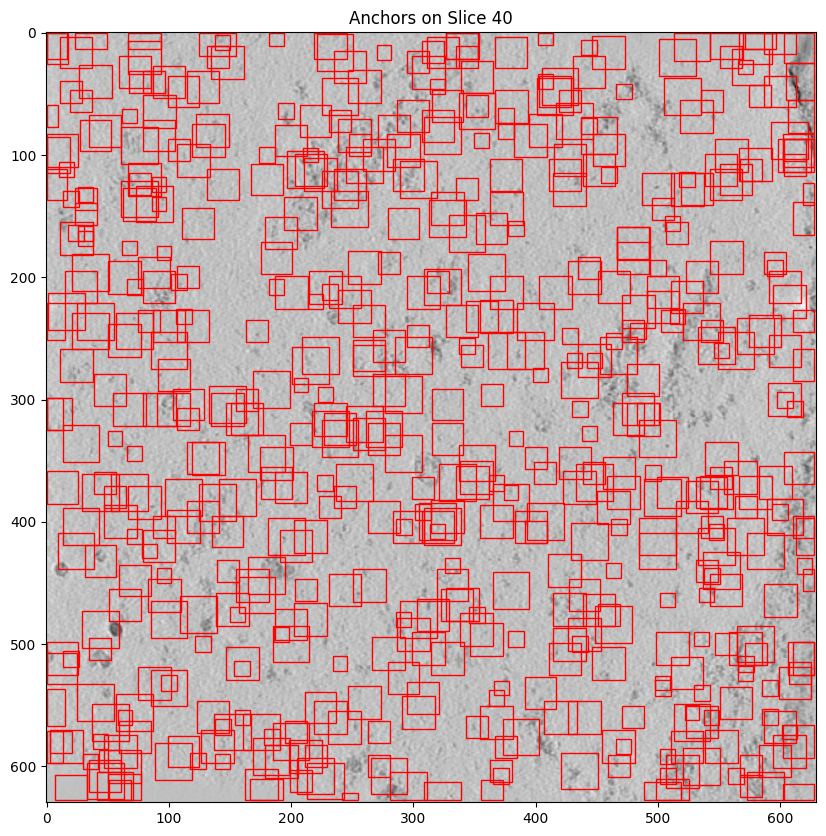

In [15]:
def visualize_anchors(tomogram, anchor_boxes, slice_index,strides, max_anchors=100):
    """
    Visualizes a subset of anchor boxes on a specific slice of the tomogram.

    Args:
        tomogram (np.ndarray): 3D tomogram data.
        anchors (np.ndarray): Array of anchor boxes with shape (N, 6).
        slice_index (int): Index of the slice to visualize.
        max_anchors (int): Maximum number of anchors to visualize.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(tomogram[slice_index], cmap='gray')
    ax = plt.gca()
    count = 0
    
    num_boxes = anchor_boxes.shape[0]
    indices = np.random.choice(num_boxes, size=max_anchors, replace=False)
    random_anchors=anchor_boxes[indices]
    
    for anchor in random_anchors:
        
        # Convert anchor box to image space
        x_min = anchor[0] * strides[0]
        y_min = anchor[1] * strides[1]
        z_min = anchor[2] * strides[2]
        x_max = anchor[3] * strides[0]
        y_max = anchor[4] * strides[1]
        z_max = anchor[5] * strides[2]
        
        if z_min <= slice_index < z_max:
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.title(f"Anchors on Slice {slice_index}")
    plt.show() 
    
# Visualize a subset of anchors on a specific slice
slice_index = 40
strides=stride_z,stride_y,stride_x

visualize_anchors(tomograms_train[0]['tomogram'], tomograms_train[0]['anchor_boxes'], slice_index, strides, max_anchors=5000)

In [16]:
@njit
def floor_div(a, b):
    return np.floor(a / b).astype(np.int32)

def get_grid_indices(boxes, grid_min, grid_cell_size, grid_size):
    """
    Compute the grid cell indices (min and max) for each box.

    Args:
        boxes (np.ndarray): Array of boxes, shape (N, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)

    Returns:
        tuple: min_indices (N,3), max_indices (N,3)
    """
    min_indices = floor_div(boxes[:, :3] - grid_min, np.array(grid_cell_size))
    max_indices = floor_div(boxes[:, 3:6] - grid_min, np.array(grid_cell_size))
    
    # Clamp indices to be within [0, grid_size - 1]
    min_indices = np.maximum(min_indices, 0)
    max_indices = np.minimum(max_indices, np.array(grid_size) - 1)
    
    return min_indices, max_indices

def assign_gt_to_grid(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size):
    """
    Assign GT boxes to grid cells.

    Args:
        ground_truth_boxes_fm (np.ndarray): GT boxes in feature map space, shape (M, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)

    Returns:
        dict: Mapping from grid cell ID to list of GT box indices
    """
    M = ground_truth_boxes_fm.shape[0]
    gt_min_idx, gt_max_idx = get_grid_indices(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size)  # (M,3), (M,3)
    
    grid_dict = defaultdict(list)
    
    for gt_idx in range(M):
        x_min, y_min, z_min = gt_min_idx[gt_idx]
        x_max, y_max, z_max = gt_max_idx[gt_idx]
        
        for x in range(x_min, x_max + 1):
            for y in range(y_min, y_max + 1):
                for z in range(z_min, z_max + 1):
                    grid_id = x * grid_size[1] * grid_size[2] + y * grid_size[2] + z
                    grid_dict[grid_id].append(gt_idx)
    
    return grid_dict

def retrieve_relevant_gt(anchor_boxes, grid_min, grid_cell_size, grid_size, grid_dict, batch_size=10000):
    """
    Retrieve relevant GT boxes for each anchor based on grid cell overlap.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (N, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)
        grid_dict (dict): Mapping from grid cell ID to list of GT box indices
        batch_size (int): Number of anchors to process in each batch

    Returns:
        list of lists: Each sublist contains GT box indices relevant to the anchor
    """
    N = anchor_boxes.shape[0]
    print('Getting grid index for each anchor box')
    anchor_min_idx, anchor_max_idx = get_grid_indices(anchor_boxes, grid_min, grid_cell_size, grid_size)  # (N,3), (N,3)
    
    relevant_gt_per_anchor = [[] for _ in range(N)]
    
    print('Finding relevant ground truth boxes for each anchor')
    for start in tqdm(range(0, N, batch_size)):
        end = min(start + batch_size, N)
        batch_min = anchor_min_idx[start:end]  # (B,3)
        batch_max = anchor_max_idx[start:end]  # (B,3)
        
        for i in range(end - start):
            anchor_idx = start + i
            x_min, y_min, z_min = batch_min[i]
            x_max, y_max, z_max = batch_max[i]
            
            grid_ids = []
            for x in range(x_min, x_max + 1):
                for y in range(y_min, y_max + 1):
                    for z in range(z_min, z_max + 1):
                        grid_id = x * grid_size[1] * grid_size[2] + y * grid_size[2] + z
                        grid_ids.append(grid_id)
            
            gt_indices = []
            for grid_id in grid_ids:
                if grid_id in grid_dict:
                    gt_indices.extend(grid_dict[grid_id])
            
            # Remove duplicates
            gt_indices = list(set(gt_indices))
            relevant_gt_per_anchor[anchor_idx] = gt_indices
    
    return relevant_gt_per_anchor

def compute_iou_3d(boxes1, boxes2):
    """
    Computes IoU between two sets of 3D boxes using float32 for efficiency.

    Args:
        boxes1 (np.ndarray): Shape (N, 6) - [x_min, y_min, z_min, x_max, y_max, z_max].
        boxes2 (np.ndarray): Shape (M, 6) - [x_min, y_min, z_min, x_max, y_max, z_max].

    Returns:
        np.ndarray: IoU array of shape (N,)
    """
    # Compute intersection coordinates
    x_min = np.maximum(boxes1[:, 0], boxes2[:, 0])
    y_min = np.maximum(boxes1[:, 1], boxes2[:, 1])
    z_min = np.maximum(boxes1[:, 2], boxes2[:, 2])
    x_max = np.minimum(boxes1[:, 3], boxes2[:, 3])
    y_max = np.minimum(boxes1[:, 4], boxes2[:, 4])
    z_max = np.minimum(boxes1[:, 5], boxes2[:, 5])

    # Compute intersection dimensions
    inter_w = np.maximum(0, x_max - x_min)
    inter_h = np.maximum(0, y_max - y_min)
    inter_d = np.maximum(0, z_max - z_min)
    intersection = inter_w * inter_h * inter_d  # (N,)

    # Compute volumes
    volume1 = (boxes1[:, 3] - boxes1[:, 0]) * \
              (boxes1[:, 4] - boxes1[:, 1]) * \
              (boxes1[:, 5] - boxes1[:, 2])  # (N,)
    volume2 = (boxes2[:, 3] - boxes2[:, 0]) * \
              (boxes2[:, 4] - boxes2[:, 1]) * \
              (boxes2[:, 5] - boxes2[:, 2])  # (M,)

    # Compute union volume
    union = volume1 + volume2 - intersection  # (N,)

    # Compute IoU
    iou = intersection / np.maximum(union, 1e-6)  # Avoid division by zero

    return iou.astype(np.float32)  # Ensure float32

@njit(parallel=True)
def compute_deltas_batch_numba(anchor_boxes, gt_boxes, stride_array, deltas):
    """
    Numba-accelerated computation of deltas for a batch of anchors and GT boxes.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in image space, shape (K, 6).
                    stride_array (np.ndarray): Stride factors, shape (6,)
        deltas (np.ndarray): Output array for deltas, shape (K, 6).
    """
    K = anchor_boxes.shape[0]
    for i in prange(K):
        # Convert anchor box to image space
        x_min_a = anchor_boxes[i, 0] * stride_array[0]
        y_min_a = anchor_boxes[i, 1] * stride_array[1]
        z_min_a = anchor_boxes[i, 2] * stride_array[2]
        x_max_a = anchor_boxes[i, 3] * stride_array[3]
        y_max_a = anchor_boxes[i, 4] * stride_array[4]
        z_max_a = anchor_boxes[i, 5] * stride_array[5]
        
        # Compute centers and sizes
        x_a = (x_min_a + x_max_a) / 2.0
        y_a = (y_min_a + y_max_a) / 2.0
        z_a = (z_min_a + z_max_a) / 2.0
        w_a = x_max_a - x_min_a
        h_a = y_max_a - y_min_a
        d_a = z_max_a - z_min_a
        
        # GT box in image space
        x_min_g = gt_boxes[i, 0] * stride_array[0]
        y_min_g = gt_boxes[i, 1] * stride_array[1]
        z_min_g = gt_boxes[i, 2] * stride_array[2]
        x_max_g = gt_boxes[i, 3] * stride_array[3]
        y_max_g = gt_boxes[i, 4] * stride_array[4]
        z_max_g = gt_boxes[i, 5] * stride_array[5]
        
        x_g = (x_min_g + x_max_g) / 2.0
        y_g = (y_min_g + y_max_g) / 2.0
        z_g = (z_min_g + z_max_g) / 2.0
        w_g = x_max_g - x_min_g
        h_g = y_max_g - y_min_g
        d_g = z_max_g - z_min_g
        
        # Compute deltas
        dx = (x_g - x_a) / w_a
        dy = (y_g - y_a) / h_a
        dz = (z_g - z_a) / d_a
        dw = np.log(w_g / w_a)
        dh = np.log(h_g / h_a)
        dd = np.log(d_g / d_a)
        
        # Assign to deltas array
        deltas[i, 0] = dx
        deltas[i, 1] = dy
        deltas[i, 2] = dz
        deltas[i, 3] = dw
        deltas[i, 4] = dh
        deltas[i, 5] = dd

def match_anchors_optimized(
    anchor_boxes, 
    ground_truth_boxes_fm, 
    ground_truth_labels, 
    stride=(4,4,4), 
    iou_thresholds=(0.3, 0.7), 
    grid_cell_size=(10.0, 10.0, 10.0)
):
    """
    Optimized matching of anchors to ground truth boxes using grid-based spatial partitioning.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes in feature map space with shape (N, 6).
        ground_truth_boxes_fm (np.ndarray): Array of ground truth boxes in feature map space with shape (M, 6).
        ground_truth_labels (np.ndarray): Array of ground truth labels with shape (M,).
        feature_map_shape (tuple): Shape of the feature map (batch_size, D, H, W, C).
        stride (tuple): Stride factors along (z, y, x).
        iou_thresholds (tuple): Tuple of (low_threshold, high_threshold) for negative and positive IoU.
        grid_cell_size (tuple): Size of each grid cell along (x, y, z).

    Returns:
        tuple: (anchor_labels, anchor_deltas, best_gt_idx)
            - anchor_labels (np.ndarray): Labels for each anchor (-1: ignored, -2: background, >0: class labels).
            - anchor_deltas (np.ndarray): Deltas (dx, dy, dz, dw, dh, dd) for each positive anchor.
            - best_gt_idx (np.ndarray): Indices of the best ground truth box for each anchor.
    """
    low_threshold, high_threshold = iou_thresholds
    N = anchor_boxes.shape[0]
    M = ground_truth_boxes_fm.shape[0]
    
    # Initialize labels and deltas
    anchor_labels = np.full(N, -1, dtype=np.int32)      # -1: ignore
    anchor_deltas = np.zeros((N, 6), dtype=np.float32)  # Deltas for positive anchors
    best_gt_idx = np.full(N, -1, dtype=np.int32)        # Best GT index for each anchor
    anchor_best_gt_iou = np.full(N, 0, dtype=np.float32)  # Best GT IOU for each anchor
    
    # Compute grid boundaries
    print('Computing grid boundaries')
    all_boxes = np.vstack((anchor_boxes, ground_truth_boxes_fm))
    grid_min = all_boxes[:, :3].min(axis=0)  # (x_min, y_min, z_min)
    grid_max = all_boxes[:, 3:6].max(axis=0)  # (x_max, y_max, z_max)
    
    # Compute grid size
    grid_size = np.ceil((grid_max - grid_min) / grid_cell_size).astype(int)
    grid_size = tuple(grid_size)  # (x_cells, y_cells, z_cells)
    
    # Assign GT boxes to grid cells
    print('Assigning GT boxes to grid cells')
    grid_dict = assign_gt_to_grid(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size)
    
    # Retrieve relevant GT boxes for each anchor
    print('Retrieving relevant GT boxes for each anchor')
    relevant_gt_per_anchor = retrieve_relevant_gt(anchor_boxes, grid_min, grid_cell_size, grid_size, grid_dict, batch_size=10000)
    
    # Compute deltas requires stride information applied appropriately
    stride_array = np.array([
        stride[2], stride[1], stride[0],  # x, y, z for min coords
        stride[2], stride[1], stride[0]   # x, y, z for max coords
    ], dtype=np.float32)
    
    # Iterate over each anchor to assign labels and compute deltas
    print('Computing IOU between each anchor box and their relevant ground truth boxes and assigning particle labels')
    
    test = True  
    for anchor_idx in tqdm(range(N)):
        gt_indices = relevant_gt_per_anchor[anchor_idx]
        if len(gt_indices) == 0:
            # No overlapping GT boxes, assign as background
            anchor_labels[anchor_idx] = -2
            continue
        
        # Extract the anchor and relevant GT boxes
        anchor_box = anchor_boxes[anchor_idx].astype(np.float32).reshape(1,6)
        gt_boxes = ground_truth_boxes_fm[gt_indices].astype(np.float32)  # (k,6)
        
        # Compute IoUs
        ious = compute_iou_3d(anchor_box, gt_boxes)  # (k,)
        
        # Find the GT box with the maximum IoU
        max_iou_idx = np.argmax(ious)
        max_iou = ious[max_iou_idx]
        
        if max_iou == 0:
            # No overlapping GT boxes, assign as background - this is because retrieve_relevant_gt function not quite right
            anchor_labels[anchor_idx] = -2
            continue
            
        best_gt = gt_indices[max_iou_idx]
        
        anchor_best_gt_iou[anchor_idx] = max_iou
        
        if max_iou >= high_threshold:
            anchor_labels[anchor_idx] = ground_truth_labels[best_gt]
            # Compute deltas
            deltas = compute_iou_deltas(anchor_box, ground_truth_boxes_fm[best_gt].reshape(1,6), stride_array)
            anchor_deltas[anchor_idx] = deltas[0]
            best_gt_idx[anchor_idx] = best_gt
        elif max_iou < low_threshold:
            anchor_labels[anchor_idx] = -2  # Background
        else:
            anchor_labels[anchor_idx] = -1  # Ignore
        
    print('Anchor matching completed.')
    return anchor_labels, anchor_deltas, best_gt_idx,anchor_best_gt_iou

@njit(parallel=True)
def compute_iou_deltas_numba(anchor_boxes, gt_boxes, stride_array, deltas):
    """
    Numba-accelerated computation of deltas for a batch of anchors and GT boxes.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in image space, shape (K, 6).
        stride_array (np.ndarray): Stride factors, shape (6,)
        deltas (np.ndarray): Output array for deltas, shape (K, 6).
    """
    K = anchor_boxes.shape[0]
    for i in prange(K):
        # Convert anchor box to image space
        x_min_a = anchor_boxes[i, 0] * stride_array[0]
        y_min_a = anchor_boxes[i, 1] * stride_array[1]
        z_min_a = anchor_boxes[i, 2] * stride_array[2]
        x_max_a = anchor_boxes[i, 3] * stride_array[3]
        y_max_a = anchor_boxes[i, 4] * stride_array[4]
        z_max_a = anchor_boxes[i, 5] * stride_array[5]
        
        # Compute centers and sizes
        x_a = (x_min_a + x_max_a) / 2.0
        y_a = (y_min_a + y_max_a) / 2.0
        z_a = (z_min_a + z_max_a) / 2.0
        w_a = x_max_a - x_min_a
        h_a = y_max_a - y_min_a
        d_a = z_max_a - z_min_a
        
        # GT box in image space
        x_min_g = gt_boxes[i, 0] * stride_array[0]
        y_min_g = gt_boxes[i, 1] * stride_array[1]
        z_min_g = gt_boxes[i, 2] * stride_array[2]
        x_max_g = gt_boxes[i, 3] * stride_array[3]
        y_max_g = gt_boxes[i, 4] * stride_array[4]
        z_max_g = gt_boxes[i, 5] * stride_array[5]
        
        x_g = (x_min_g + x_max_g) / 2.0
        y_g = (y_min_g + y_max_g) / 2.0
        z_g = (z_min_g + z_max_g) / 2.0
        w_g = x_max_g - x_min_g
        h_g = y_max_g - y_min_g
        d_g = z_max_g - z_min_g
        
        # Compute deltas
        dx = (x_g - x_a) / w_a
        dy = (y_g - y_a) / h_a
        dz = (z_g - z_a) / d_a
        dw = np.log(w_g / w_a)
        dh = np.log(h_g / h_a)
        dd = np.log(d_g / d_a)
        
        # Assign to deltas array
        deltas[i, 0] = dx
        deltas[i, 1] = dy
        deltas[i, 2] = dz
        deltas[i, 3] = dw
        deltas[i, 4] = dh
        deltas[i, 5] = dd

def compute_iou_deltas(anchor_boxes, gt_boxes, stride_array):
    """
    Wrapper function to compute deltas using Numba-accelerated function.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in feature map space, shape (K, 6).
        stride_array (np.ndarray): Stride factors, shape (6,)

    Returns:
        np.ndarray: Deltas (K, 6)
    """
    K = anchor_boxes.shape[0]
    deltas = np.zeros((K, 6), dtype=np.float32)
    compute_iou_deltas_numba(anchor_boxes, gt_boxes, stride_array, deltas)
    return deltas

grid_cell_size=(5.0, 5.0, 5.0)
stride = (stride_z, stride_y, stride_x)

stride_array = np.array([
    stride[2], stride[1], stride[0],  # x, y, z for min coords
    stride[2], stride[1], stride[0]   # x, y, z for max coords
])

tomogram_sample=1

for idx,tomo in enumerate(tomograms_train):
    print(f'*** Processing tomogram {idx}/{len(tomograms_train)-1} ***')
    
    # Project ground truth boxes to feature map space
    print('Calculating ground truth boxes in feature map space...')
    tomo['ground_truth_boxes_fm'] = tomo['ground_truth_boxes'] / stride_array.reshape(1,6)  # (M,6)
    
    # Perform optimized matching
    tomo['anchor_labels'], tomo['anchor_deltas'], tomo['best_gt_idx'], tomo['anchor_best_gt_iou'] = match_anchors_optimized(
        anchor_boxes=tomo['anchor_boxes'],
        ground_truth_boxes_fm=tomo['ground_truth_boxes_fm'],
        ground_truth_labels=tomo['ground_truth_labels'],
        stride=stride,
        iou_thresholds=(0.3,0.6),
        grid_cell_size=grid_cell_size
    )

# Verify the number of positive matches
num_positive = np.sum(tomograms_train[0]['anchor_labels'] > -1)
num_background = np.sum(tomograms_train[0]['anchor_labels'] == -2)
num_ignored = np.sum(tomograms_train[0]['anchor_labels'] == -1)
print(f"Number of positive anchors: {num_positive}")
print(f"Number of background anchors: {num_background}")
print(f"Number of ignored anchors: {num_ignored}")

*** Processing tomogram 0/0 ***
Calculating ground truth boxes in feature map space...
Computing grid boundaries
Assigning GT boxes to grid cells
Retrieving relevant GT boxes for each anchor
Getting grid index for each anchor box
Finding relevant ground truth boxes for each anchor


100%|██████████| 690/690 [00:30<00:00, 22.45it/s]


Computing IOU between each anchor box and their relevant ground truth boxes and assigning particle labels


100%|██████████| 6890064/6890064 [00:38<00:00, 180784.38it/s] 


Anchor matching completed.
Number of positive anchors: 1522
Number of background anchors: 6863125
Number of ignored anchors: 25417


In [17]:
for tomo in tomograms_train:
    print(f'Run: {tomo['run']} - {len(np.unique(tomo['best_gt_idx']))-1}/{len(tomo['ground_truth_boxes_fm'])} particles assigned at least one anchor box')

    print('Number of each particle type assigned at least one anchor box:')
    holder={}
    for i,v in zip(tomo['anchor_labels'],tomo['best_gt_idx']):
        if i>-1:
            holder[int(v)]=tomo['id_to_label'][int(i)]
    for particle in particle_types:
        print(f'{particle}: {len([i for i,v in holder.items() if v==particle])}/{len([i for i in tomo['ground_truth_labels'] if i == tomo['label_to_id'][particle]])}')

Run: TS_5_4 - 118/140 particles assigned at least one anchor box
Number of each particle type assigned at least one anchor box:
apo-ferritin: 30/46
beta-amylase: 6/10
beta-galactosidase: 10/12
ribosome: 31/31
thyroglobulin: 30/30
virus-like-particle: 11/11


In [18]:
def convert_anchor_boxes_to_image_space(anchor_boxes: np.ndarray, stride_array: tuple) -> np.ndarray:
    """
    Converts anchor boxes from feature map coordinates to image space coordinates.

    Args:
        anchor_boxes (np.ndarray): 
            A 2D NumPy array of shape (N, 6) representing anchor boxes in feature map coordinates.
            Each anchor box is defined as [x_min, y_min, z_min, x_max, y_max, z_max].
        stride_array (tuple): 
            A tuple of strides defining the scaling between feature map and image space.
            Format: (stride_z, stride_y, stride_x).

    Returns:
        np.ndarray: 
            A 2D NumPy array of shape (N, 6) representing anchor boxes in image space coordinates.
            Each anchor box is defined as [x_min, y_min, z_min, x_max, y_max, z_max].

    Raises:
        ValueError: 
            If `anchor_boxes` is not a 2D array with shape (N, 6).
            If `stride_array` does not contain exactly three positive numerical values.
    """
    # Input Validation
    if not isinstance(anchor_boxes, np.ndarray):
        raise TypeError("anchor_boxes must be a NumPy array.")
    if anchor_boxes.ndim != 2 or anchor_boxes.shape[1] != 6:
        raise ValueError("anchor_boxes must be a 2D NumPy array with shape (N, 6).")
    if not (isinstance(stride_array, tuple) or isinstance(stride_array, list)):
        raise TypeError("stride_array must be a tuple or list of three numerical values.")
    if len(stride_array) != 3:
        raise ValueError("stride_array must contain exactly three elements: (stride_z, stride_y, stride_x).")
    if not all(isinstance(s, (int, float)) and s > 0 for s in stride_array):
        raise ValueError("All elements in stride_array must be positive numbers.")
    
    # Convert anchor_boxes to float32 for precision in calculations
    anchor_boxes = anchor_boxes.astype(np.float32)
    
    # Extract strides
    stride_z, stride_y, stride_x = stride_array
    
    # Initialize a copy to avoid modifying the original anchor_boxes
    image_space_anchors = anchor_boxes.copy()
    
    # Vectorized multiplication to convert from feature map to image space
    # [x_min, y_min, z_min, x_max, y_max, z_max]
    image_space_anchors[:, 0] *= stride_x  # x_min
    image_space_anchors[:, 1] *= stride_y  # y_min
    image_space_anchors[:, 2] *= stride_z  # z_min
    image_space_anchors[:, 3] *= stride_x  # x_max
    image_space_anchors[:, 4] *= stride_y  # y_max
    image_space_anchors[:, 5] *= stride_z  # z_max
    
    return image_space_anchors

# Define stride array: (stride_z, stride_y, stride_x)
stride_array = (4, 4, 4)  # Example strides

# for tomo in tomograms_train:
    # Convert anchor boxes to image space
    # tomo['anchor_boxes_image_space'] = convert_anchor_boxes_to_image_space(tomo['anchor_boxes'], stride_array)

In [19]:
# def generate_subvolumes_with_gt_and_anchors(tomograms_train ,sub_volume_size,sub_volume_stride,stride_array):
#     """
#     Generator that yields subvolumes from tomograms along with their associated data.
#     
#     Args:
#         tomograms_train (List[Dict]): List of tomogram dictionaries.
#         sub_volume_size (tuple): Size of each subvolume as (D, H, W).
#         sub_volume_stride (tuple): Stride for moving the window as (D, H, W).
#         stride_array (tuple): Stride defining scaling between feature map and image space 
#                               as (stride_z, stride_y, stride_x).
#     
#     Yields:
#         Dict: Dictionary containing subvolume data and associated parameters.
#     """
#     # print('Generating subvolumes and assigning ground truth and anchor boxes...')
#     
#     for tomo in tomograms_train:
#         run_name = tomo['run']
#         tomogram = tomo['tomogram']
#         global_anchor_boxes = tomo['anchor_boxes']        # Shape: (N, 6)
#         global_anchor_centres = tomo['anchor_centres']
#         global_anchor_best_gt_idx = tomo['best_gt_idx']   # Shape: (N,)
#         global_anchor_labels = tomo['anchor_labels']      # Shape: (N,)
#         global_anchor_deltas = tomo['anchor_deltas']      # Shape: (N, 6)
#         global_gt_boxes = tomo['ground_truth_boxes']
#         global_gt_labels = tomo['ground_truth_labels']
#         global_gt_indices = tomo['ground_truth_indices']
#         particle_locations = tomo['particle_locations']   # Assuming this key exists and is a DataFrame
#                 
#         # Convert anchor boxes to image space
#         # anchor_boxes_img = convert_anchor_boxes_to_image_space(global_anchor_boxes, stride_array)
#     
#         # Subdivide the tomogram into subvolumes
#         subvolumes = subdivide_tomogram(tomogram, sub_volume_size, sub_volume_stride)
#         
#         if not subvolumes:
#             continue
# 
#         sub_D, sub_H, sub_W = sub_volume_size
# 
#         # Ensure data types
#         global_anchor_labels = global_anchor_labels.astype(np.int32)
#         global_anchor_deltas = global_anchor_deltas.astype(np.float32)
# 
#         for sub in subvolumes:
#             sub_tomogram = sub['tomogram']
#             origin = sub['origin']  # (x_start, y_start, z_start)
#             x_start, y_start, z_start = origin
# 
#             # Define subvolume bounds in image coordinates
#             x_end = x_start + sub_W
#             y_end = y_start + sub_H
#             z_end = z_start + sub_D            
#                         
#             subvolume_fm = np.zeros(6)
# 
#             subvolume_fm[0] = x_start / stride_x  # x_min
#             subvolume_fm[1] = y_start / stride_y  # y_min
#             subvolume_fm[2] = z_start / stride_z  # z_min
#             subvolume_fm[3] = x_end / stride_x  # x_max
#             subvolume_fm[4] = y_end / stride_y  # y_max
#             subvolume_fm[5] = z_end / stride_z  # z_max
# 
#             overlap_mask = (
#                 (global_anchor_boxes[:, 0] >= subvolume_fm[0]) & (global_anchor_boxes[:, 3] <= subvolume_fm[3]) &
#                 (global_anchor_boxes[:, 1] >= subvolume_fm[1]) & (global_anchor_boxes[:, 4] <= subvolume_fm[4]) &
#                 (global_anchor_boxes[:, 2] >= subvolume_fm[2]) & (global_anchor_boxes[:, 5] <= subvolume_fm[5])
#             )
# 
#             # print(f'subvolume_fm: {subvolume_fm}')
# 
#             # Compute the center of each anchor box
#             x_centre = global_anchor_centres[:, 0]
#             y_centre = global_anchor_centres[:, 1]
#             z_centre = global_anchor_centres[:, 2]
#             
#             # print(global_anchor_centres[:, 0])
#             
#             # Create the mask by checking if the center is within the subvolume bounds
#             overlap_mask = (
#                 (x_centre >= subvolume_fm[0]) & (x_centre < subvolume_fm[3]) &
#                 (y_centre >= subvolume_fm[1]) & (y_centre < subvolume_fm[4]) &
#                 (z_centre >= subvolume_fm[2]) & (z_centre < subvolume_fm[5])
#             )
# 
#             # Select overlapping anchors
#             if not np.any(overlap_mask):
#                 continue  # No anchors overlap with this subvolume
# 
#             filtered_anchor_indices =       np.where(overlap_mask)[0]                                   # Shape: (num_filtered_anchors,)
#             filtered_anchors =              global_anchor_boxes[filtered_anchor_indices].copy()         # Shape: (num_filtered_anchors, 6)
#             filtered_anchor_labels =        global_anchor_labels[filtered_anchor_indices].copy()        # Shape: (num_filtered_anchors,)
#             filtered_anchor_deltas =        global_anchor_deltas[filtered_anchor_indices].copy()        # Shape: (num_filtered_anchors, 6)
#             
#             filtered_anchor_best_gt_idx =   global_anchor_best_gt_idx[filtered_anchor_indices].copy()   # Shape: (num_filtered_anchors, 6)
#             filtered_anchor_best_gt_box_adjusted = global_gt_boxes[filtered_anchor_best_gt_idx].copy() - np.tile(origin, 2)    # Shape: (num_filtered_anchors, 6)
#             
#             # Get mask to filter particles in subvolume
#             particle_mask = get_subvolume_ground_truth(particle_locations, origin, sub_volume_size)
#             
#             filtered_gt_indices =   np.array(global_gt_indices)[particle_mask].copy()
#             filtered_gt_boxes =     np.array(global_gt_boxes)[particle_mask].copy()
#             filtered_gt_labels =    np.array(global_gt_labels)[particle_mask].copy()
#         
#             # Subtract origin from all box coordinates
#             filtered_gt_boxes_adjusted = filtered_gt_boxes - np.tile(origin, 2)
#             filtered_anchor_boxes_adjusted = filtered_anchors - np.tile(origin,2)
#             
#             # Compute ground truth bounding boxes and encode labels
#             if len(filtered_gt_boxes_adjusted) ==0:
#                 filtered_gt_boxes_adjusted = np.empty((0, 6), dtype=np.float32)
#                 filtered_gt_labels = np.empty((0,), dtype=np.int32)
#                 filtered_gt_indices = np.empty((0,),dtype=np.int32)
# 
# 
#             # Yield the subvolume data
#             yield {
#                 'origin':                       origin,
#                 'run':                          run_name,
#                 'tomogram':                     sub_tomogram.astype(np.float32),        # Shape: (D, H, W)
#                 'anchor_boxes':                 filtered_anchors.astype(np.float32),    # Shape: (N, 6)
#                 'anchor_boxes_adjusted':        filtered_anchor_boxes_adjusted,         # Shape: (N, 6)
#                 'anchor_labels':                filtered_anchor_labels,                 # Shape: (N,)
#                 'anchor_deltas':                filtered_anchor_deltas,                 # Shape: (N, 6)
#                 'anchor_best_gt_box_adjusted':  filtered_anchor_best_gt_box_adjusted,   # Shape: (N, 6)
#                 'ground_truth_boxes':           filtered_gt_boxes,                      # Shape: (M, 6)
#                 'ground_truth_boxes_adjusted':  filtered_gt_boxes_adjusted,             # Shape: (M, 6)
#                 'ground_truth_indices':         filtered_gt_indices,                    # Shape: (M,)
#                 'ground_truth_labels':          filtered_gt_labels                      # Shape: (M,)
#             }
# 
# def subdivide_tomogram(tomogram: np.ndarray, sub_volume_size: tuple, sub_volume_stride: tuple) -> List[Dict]:
#     """
#     Subdivide a 3D tomogram into smaller subvolumes.
#     
#     Args:
#         tomogram (np.ndarray): 3D tomogram data.
#         sub_volume_size (tuple): Size of each subvolume (D, H, W).
#         sub_volume_stride (tuple): Stride for moving the window (D, H, W).
#     
#     Returns:
#         List[Dict]: Each dict contains 'tomogram' and 'origin' (x_start, y_start, z_start).
#     """
#     D, H, W = tomogram.shape
#     sub_D, sub_H, sub_W = sub_volume_size
#     stride_D, stride_H, stride_W = sub_volume_stride
# 
#     # Calculate the number of steps in each dimension
#     steps_z = max((D - sub_D) // stride_D + 1, 1)
#     steps_y = max((H - sub_H) // stride_H + 1, 1)
#     steps_x = max((W - sub_W) // stride_W + 1, 1)
# 
#     # Precompute the start indices for each dimension
#     starts_z = np.linspace(0, D - sub_D, num=steps_z, dtype=int)
#     starts_y = np.linspace(0, H - sub_H, num=steps_y, dtype=int)
#     starts_x = np.linspace(0, W - sub_W, num=steps_x, dtype=int)
# 
#     # Generate all possible combinations of start indices
#     grid_z, grid_y, grid_x = np.meshgrid(starts_z, starts_y, starts_x, indexing='ij')
#     origins = np.stack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()], axis=1)  # Shape: (num_subvolumes, 3)
# 
#     # Extract subvolumes using advanced indexing
#     subvolumes = []
#     for origin in origins:
#         x_start, y_start, z_start = origin
#         sub = tomogram[z_start:z_start + sub_D, y_start:y_start + sub_H, x_start:x_start + sub_W]
#         subvolumes.append({'tomogram': sub, 'origin': tuple(origin)})
# 
#     return subvolumes
# 
# def get_subvolume_ground_truth(particle_df, sub_volume_origin, sub_volume_size):
#     """
#     Extract ground truth boxes within a subvolume.
#     
#     Args:
#         particle_df (pd.DataFrame): DataFrame with particle locations and labels.
#         sub_volume_origin (tuple): (x_start, y_start, z_start) of the subvolume.
#         sub_volume_size (tuple): (D, H, W) size of the subvolume.
#     
#     Returns:
#         pd.DataFrame: Ground truth boxes within the subvolume.
#     """
#     
#     x_start, y_start, z_start = sub_volume_origin
#     D, H, W = sub_volume_size
# 
#     # Define the bounds of the subvolume
#     x_end = x_start + W
#     y_end = y_start + H
#     z_end = z_start + D
# 
#     # Filter particles within the subvolume
#     mask = (
#         (particle_df['x'] >= x_start) & (particle_df['x'] < x_end) &
#         (particle_df['y'] >= y_start) & (particle_df['y'] < y_end) &
#         (particle_df['z'] >= z_start) & (particle_df['z'] < z_end)
#     )
#     
#     return mask.astype(bool)
# 
# def adjust_box(gt_boxes, sub_volume_origin):
#     sub_volume_origin = np.array(sub_volume_origin)  # Convert to NumPy array for vectorized operations
#     adjusted_gt_boxes = gt_boxes - np.tile(sub_volume_origin, 2)  # Subtract origin from all box coordinates
#     return adjusted_gt_boxes
# 
# def compute_bbox_deltas(proposal, ground_truth):
#     """
#     Computes the deltas between a proposal and a ground truth box.
# 
#     Args:
#         proposal (np.ndarray): Array of shape (6,) [x_min, y_min, z_min, x_max, y_max, z_max].
#         ground_truth (np.ndarray): Array of shape (6,) [x_min, y_min, z_min, x_max, y_max, z_max].
# 
#     Returns:
#         deltas (np.ndarray): Array of shape (6,) [dx, dy, dz, dw, dh, dd].
#     """
#     # Compute proposal center and size
#     x_p = (proposal[0] + proposal[3]) / 2.0
#     y_p = (proposal[1] + proposal[4]) / 2.0
#     z_p = (proposal[2] + proposal[5]) / 2.0
#     w_p = proposal[3] - proposal[0]
#     h_p = proposal[4] - proposal[1]
#     d_p = proposal[5] - proposal[2]
# 
#     # Compute ground truth center and size
#     x_gt = (ground_truth[0] + ground_truth[3]) / 2.0
#     y_gt = (ground_truth[1] + ground_truth[4]) / 2.0
#     z_gt = (ground_truth[2] + ground_truth[5]) / 2.0
#     w_gt = ground_truth[3] - ground_truth[0]
#     h_gt = ground_truth[4] - ground_truth[1]
#     d_gt = ground_truth[5] - ground_truth[2]
# 
#     # Compute deltas
#     dx = (x_gt - x_p) / w_p
#     dy = (y_gt - y_p) / h_p
#     dz = (z_gt - z_p) / d_p
#     dw = np.log(w_gt / w_p)
#     dh = np.log(h_gt / h_p)
#     dd = np.log(d_gt / d_p)
# 
#     deltas = np.array([dx, dy, dz, dw, dh, dd], dtype=np.float32)
#     return deltas
# 
# def data_generator(tomograms_train, sub_volume_size, sub_volume_stride, stride_array):
#     """
#     Generator that yields (inputs, labels) for Faster R-CNN training.
# 
#     Args:
#         tomograms_train (List[Dict]): List of tomogram dictionaries.
#         sub_volume_size (tuple): Size of each subvolume (D, H, W).
#         sub_volume_stride (tuple): Stride for moving the window (D, H, W).
#         stride_array (tuple): Stride for scaling anchor boxes (stride_z, stride_y, stride_x).
# 
#     Yields:
#         Tuple[Dict, Dict]: (inputs, labels)
#             - inputs:
#                 'subvolume': np.ndarray of shape (D, H, W, 1)
#                 'anchor_boxes': np.ndarray of shape (N, 6)
#             - labels:
#                 'class_logits': np.ndarray of shape (N, num_classes)
#                 'bbox_deltas_final': np.ndarray of shape (N, 6)
#     """
#     
#     for idx,data in enumerate(generate_subvolumes_with_gt_and_anchors(tomograms_train, sub_volume_size, sub_volume_stride, stride_array)):
#         anchor_labels =                 data['anchor_labels']
#         gt_boxes_adjusted =             data['ground_truth_boxes_adjusted']
#         gt_labels =                     data['ground_truth_labels']
# 
#         rpn_objectness_labels = (anchor_labels > -1).astype(np.float32)  # 1 for object, 0 for background
#         rpn_bbox_targets = data['anchor_deltas'].astype(np.float32)
#         
#         labels = {
#             'objectness_out':rpn_objectness_labels,     # Shape: (N,)
#             'bbox_deltas_out':rpn_bbox_targets,         # Shape: (N, 6)
#             'ground_truth_boxes':gt_boxes_adjusted,
#             'ground_truth_labels':gt_labels
#         }
# 
#         inputs = {
#             'tomogram': data['tomogram'][..., np.newaxis].astype(np.float32),
#             'anchor_boxes': data['anchor_boxes'].astype(np.float32)
#         }
# 
#         yield (inputs, labels)
# 
# 
# sub_volume_size = (50, 100, 100)    # (D, H, W)
# sub_volume_stride = (25, 50, 50)     # (D, H, W)
# 
# sub_volume_size_fm = (int(np.ceil(sub_volume_size[0]/stride_x)),int(np.ceil(sub_volume_size[1]/stride_y)),int(np.ceil(sub_volume_size[2]/stride_z)))
# number_of_anchors = sub_volume_size_fm[0]*sub_volume_size_fm[1]*sub_volume_size_fm[2]
# number_of_anchor_boxes = number_of_anchors*boxes_per_anchors
# 
# max_proposals=20
# 
# # Define output signature
# output_signature = (
#     {
#         'tomogram': tf.TensorSpec(shape=(*sub_volume_size, 1), dtype=tf.float32),  # (D, H, W, 1)
#         'anchor_boxes': tf.TensorSpec(shape=(number_of_anchor_boxes, 6), dtype=tf.float32)  # (total_anchors, 6)
#     },
#     {
#         'objectness_out': tf.TensorSpec(shape=(number_of_anchor_boxes,), dtype=tf.float32),           # (total_anchors,)
#         'bbox_deltas_out': tf.TensorSpec(shape=(number_of_anchor_boxes, 6), dtype=tf.float32),      # (total_anchors, 6)
#         'ground_truth_boxes': tf.TensorSpec(shape=(None, 6), dtype=tf.float32),                     # (num_gt, 6)
#         'ground_truth_labels': tf.TensorSpec(shape=(None,), dtype=tf.int32)                        # (num_gt,)
#     }
# )
# 
# print('Defining dataset')
# # Create the dataset without batching
# dataset = tf.data.Dataset.from_generator(
#     lambda: data_generator(tomograms_train, sub_volume_size, sub_volume_stride, stride_array),
#     output_signature=output_signature
# )
# 
# print('Building dataset batch')
# dataset = dataset.batch(1)
# print('Built dataset batch')

In [20]:
import numpy as np
import tensorflow as tf
import pandas as pd
from typing import List, Dict
import itertools
import random

# -----------------------------
# Helper Functions
# -----------------------------

def subdivide_tomogram(
    tomogram: np.ndarray,
    sub_volume_size: tuple,
    sub_volume_stride: tuple,
    run_name: str,
    id_start: int
) -> List[Dict]:
    """
    Subdivide a 3D tomogram into smaller subvolumes, ensuring all subvolumes are of exact size without padding.
    Each subvolume is entirely within the tomogram.

    Args:
        tomogram (np.ndarray): 3D tomogram data.
        sub_volume_size (tuple): Size of each subvolume as (D, H, W).
        sub_volume_stride (tuple): Stride for moving the window as (D, H, W).
        run_name (str): Name of the run/tomogram.
        id_start (int): Starting ID for the subvolumes.

    Returns:
        List[Dict]: Each dict contains 'id', 'tomogram', 'origin' (x_start, y_start, z_start), and 'run'.
    """
    D, H, W = tomogram.shape
    sub_D, sub_H, sub_W = sub_volume_size
    stride_D, stride_H, stride_W = sub_volume_stride

    # Calculate the possible start indices ensuring subvolume fits entirely
    starts_z = list(range(0, D - sub_D + 1, stride_D))
    starts_y = list(range(0, H - sub_H + 1, stride_H))
    starts_x = list(range(0, W - sub_W + 1, stride_W))

    # Add the last possible subvolume if the stride doesn't align perfectly
    if (D - sub_D) % stride_D != 0:
        starts_z.append(D - sub_D)
    if (H - sub_H) % stride_H != 0:
        starts_y.append(H - sub_H)
    if (W - sub_W) % stride_W != 0:
        starts_x.append(W - sub_W)

    # Remove duplicates and sort
    starts_z = sorted(set(starts_z))
    starts_y = sorted(set(starts_y))
    starts_x = sorted(set(starts_x))

    # Generate all possible combinations of start indices
    origins = list(itertools.product(starts_x, starts_y, starts_z))  # Each origin is (x_start, y_start, z_start)

    subvolumes = []
    for idx, origin in enumerate(origins):
        x_start, y_start, z_start = origin
        sub = tomogram[z_start:z_start + sub_D, y_start:y_start + sub_H, x_start:x_start + sub_W]
        subvolumes.append({
            'id': id_start + idx,
            'run': run_name,
            'tomogram': sub,
            'origin': origin  # (x_start, y_start, z_start)
        })

    return subvolumes

def get_subvolume_ground_truth(particle_df: pd.DataFrame, sub_volume_origin: tuple, sub_volume_size: tuple) -> np.ndarray:
    """
    Extract ground truth boxes within a subvolume.

    Args:
        particle_df (pd.DataFrame): DataFrame with particle locations and labels.
        sub_volume_origin (tuple): (x_start, y_start, z_start) of the subvolume.
        sub_volume_size (tuple): (D, H, W) size of the subvolume.

    Returns:
        np.ndarray: Boolean mask indicating ground truth boxes within the subvolume.
    """
    x_start, y_start, z_start = sub_volume_origin
    D, H, W = sub_volume_size

    # Define the bounds of the subvolume
    x_end = x_start + W
    y_end = y_start + H
    z_end = z_start + D

    # Filter particles within the subvolume
    mask = (
        (particle_df['x'] >= x_start) & (particle_df['x'] < x_end) &
        (particle_df['y'] >= y_start) & (particle_df['y'] < y_end) &
        (particle_df['z'] >= z_start) & (particle_df['z'] < z_end)
    )

    return mask.values  # Convert to NumPy array of bool

def compute_bbox_deltas_tf(proposals, gt_boxes):
    """
    Compute bbox deltas between proposals and ground truth boxes.

    Args:
        proposals: Tensor of shape (batch_size, max_proposals, 6)
        gt_boxes: Tensor of shape (batch_size, max_proposals, 6)

    Returns:
        deltas: Tensor of shape (batch_size, max_proposals, 6)
    """
    # Compute proposal centers and sizes
    x_p = (proposals[..., 0] + proposals[..., 3]) / 2.0
    y_p = (proposals[..., 1] + proposals[..., 4]) / 2.0
    z_p = (proposals[..., 2] + proposals[..., 5]) / 2.0
    w_p = proposals[..., 3] - proposals[..., 0]
    h_p = proposals[..., 4] - proposals[..., 1]
    d_p = proposals[..., 5] - proposals[..., 2]

    # Compute ground truth centers and sizes
    x_gt = (gt_boxes[..., 0] + gt_boxes[..., 3]) / 2.0
    y_gt = (gt_boxes[..., 1] + gt_boxes[..., 4]) / 2.0
    z_gt = (gt_boxes[..., 2] + gt_boxes[..., 5]) / 2.0
    w_gt = gt_boxes[..., 3] - gt_boxes[..., 0]
    h_gt = gt_boxes[..., 4] - gt_boxes[..., 1]
    d_gt = gt_boxes[..., 5] - gt_boxes[..., 2]

    # Compute deltas
    dx = (x_gt - x_p) / w_p
    dy = (y_gt - y_p) / h_p
    dz = (z_gt - z_p) / d_p
    dw = tf.math.log(w_gt / w_p)
    dh = tf.math.log(h_gt / h_p)
    dd = tf.math.log(d_gt / d_p)

    deltas = tf.stack([dx, dy, dz, dw, dh, dd], axis=-1)  # (batch_size, max_proposals, 6)
    return deltas

def decode_deltas_tf(anchors, deltas):
    """
    Decodes bounding box deltas into final proposals.

    Args:
        anchors: Tensor of shape (batch_size, total_anchors, 6)
        deltas: Tensor of shape (batch_size, total_anchors, 6)

    Returns:
        decoded_boxes: Tensor of shape (batch_size, total_anchors, 6)
    """
    # Compute anchor centers and sizes
    x_a = (anchors[:, :, 0] + anchors[:, :, 3]) / 2.0
    y_a = (anchors[:, :, 1] + anchors[:, :, 4]) / 2.0
    z_a = (anchors[:, :, 2] + anchors[:, :, 5]) / 2.0
    w_a = anchors[:, :, 3] - anchors[:, :, 0]
    h_a = anchors[:, :, 4] - anchors[:, :, 1]
    d_a = anchors[:, :, 5] - anchors[:, :, 2]

    # Expand dimensions for broadcasting
    x_a = tf.expand_dims(x_a, axis=-1)  # Shape: (batch_size, total_anchors, 1)
    y_a = tf.expand_dims(y_a, axis=-1)
    z_a = tf.expand_dims(z_a, axis=-1)
    w_a = tf.expand_dims(w_a, axis=-1)
    h_a = tf.expand_dims(h_a, axis=-1)
    d_a = tf.expand_dims(d_a, axis=-1)

    # Split deltas
    dx, dy, dz, dw, dh, dd = tf.split(deltas, num_or_size_splits=6, axis=-1)

    # Compute proposal centers
    x_p = x_a + dx * w_a
    y_p = y_a + dy * h_a
    z_p = z_a + dz * d_a

    # Compute proposal sizes
    w_p = w_a * tf.exp(dw)
    h_p = h_a * tf.exp(dh)
    d_p = d_a * tf.exp(dd)

    # Convert to (x_min, y_min, z_min, x_max, y_max, z_max)
    x_min = x_p - w_p / 2.0
    y_min = y_p - h_p / 2.0
    z_min = z_p - d_p / 2.0
    x_max = x_p + w_p / 2.0
    y_max = y_p + h_p / 2.0
    z_max = z_p + d_p / 2.0

    # Stack to form decoded_boxes with shape (batch_size, total_anchors, 6)
    decoded_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
    
    return decoded_boxes  # (batch_size, total_anchors, 6)

def compute_iou_3d(boxes1, boxes2):
    """
    Computes IoU between two sets of 3D bounding boxes.

    Args:
        boxes1: Tensor of shape (N, 6)
        boxes2: Tensor of shape (M, 6)

    Returns:
        iou: Tensor of shape (N, M)
    """
    # Expand dimensions to compute pairwise IoU
    boxes1 = tf.expand_dims(boxes1, 1)  # (N, 1, 6)
    boxes2 = tf.expand_dims(boxes2, 0)  # (1, M, 6)
    
    # Intersection coordinates
    x_min = tf.maximum(boxes1[..., 0], boxes2[..., 0])
    y_min = tf.maximum(boxes1[..., 1], boxes2[..., 1])
    z_min = tf.maximum(boxes1[..., 2], boxes2[..., 2])
    x_max = tf.minimum(boxes1[..., 3], boxes2[..., 3])
    y_max = tf.minimum(boxes1[..., 4], boxes2[..., 4])
    z_max = tf.minimum(boxes1[..., 5], boxes2[..., 5])
    
    # Compute intersection volume
    intersection = tf.maximum(x_max - x_min, 0.0) * \
                   tf.maximum(y_max - y_min, 0.0) * \
                   tf.maximum(z_max - z_min, 0.0)
    
    # Compute volumes
    volume1 = (boxes1[..., 3] - boxes1[..., 0]) * \
              (boxes1[..., 4] - boxes1[..., 1]) * \
              (boxes1[..., 5] - boxes1[..., 2])
    volume2 = (boxes2[..., 3] - boxes2[..., 0]) * \
              (boxes2[..., 4] - boxes2[..., 1]) * \
              (boxes2[..., 5] - boxes2[..., 2])
    
    # Compute union
    union = volume1 + volume2 - intersection
    
    # Compute IoU
    iou = tf.where(union > 0, intersection / union, tf.zeros_like(intersection))
    
    return iou  # Shape: (N, M)

def match_proposals_to_gt(proposals, gt_boxes, gt_labels, iou_threshold=0.5):
    """
    Assigns class labels and bbox deltas to proposals based on ground truth boxes.
    
    Args:
        proposals: Tensor of shape (batch_size, max_proposals, 6)
        gt_boxes: Tensor of shape (batch_size, num_gt, 6)
        gt_labels: Tensor of shape (batch_size, num_gt)
        iou_threshold: float, IoU threshold to consider a proposal as positive
    
    Returns:
        class_labels: Tensor of shape (batch_size, max_proposals), integer class labels
        bbox_deltas_final: Tensor of shape (batch_size, max_proposals, 6), bbox deltas
    """
    def match_single_proposal(args):
        proposal, gt_box, gt_label = args  # proposal: (max_proposals, 6), gt_box: (num_gt, 6), gt_label: (num_gt,)
        
        # Define the condition: whether gt_box is empty
        is_empty = tf.equal(tf.shape(gt_box)[0], 0)
        
        def assign_background():
            # If no ground truth boxes, assign all proposals to background
            class_labels = tf.zeros([tf.shape(proposal)[0]], dtype=tf.int32)  # (max_proposals,)
            deltas = tf.zeros([tf.shape(proposal)[0], 6], dtype=tf.float32)  # (max_proposals, 6)
            return class_labels, deltas
        
        def assign_with_gt():
            # Compute IoU
            iou = compute_iou_3d(proposal, gt_box)  # (max_proposals, num_gt)
            
            # Find the best IoU and corresponding ground truth index
            max_iou = tf.reduce_max(iou, axis=1)             # (max_proposals,)
            argmax_iou = tf.argmax(iou, axis=1, output_type=tf.int32)  # (max_proposals,)
            
            # Assign class labels
            assigned_labels = tf.where(
                max_iou >= iou_threshold,
                tf.gather(gt_label, argmax_iou),
                tf.zeros_like(max_iou, dtype=tf.int32)  # Background class (0)
            )  # (max_proposals,)
            
            # Gather corresponding ground truth boxes
            assigned_gt_boxes = tf.gather(gt_box, argmax_iou)  # (max_proposals, 6)
            
            # Compute bbox deltas
            deltas = compute_bbox_deltas_tf(proposal, assigned_gt_boxes)  # (max_proposals, 6)
            
            # Zero deltas for background proposals
            deltas = tf.where(
                tf.expand_dims(max_iou >= iou_threshold, axis=-1),
                deltas,
                tf.zeros_like(deltas)
            )
            
            return assigned_labels, deltas
        
        # Use tf.cond to choose the appropriate assignment
        class_labels, deltas = tf.cond(
            is_empty,
            assign_background,
            assign_with_gt
        )
        
        return class_labels, deltas
    
    # Apply the matching to each element in the batch
    class_labels, bbox_deltas_final = tf.map_fn(
        match_single_proposal,
        (proposals, gt_boxes, gt_labels),
        fn_output_signature=(
            tf.TensorSpec(shape=(None,), dtype=tf.int32),
            tf.TensorSpec(shape=(None, 6), dtype=tf.float32)
        )
    )
    
    return class_labels, bbox_deltas_final

# -----------------------------
# Subvolume Indexing
# -----------------------------

def create_subvolume_index(tomograms_train: List[Dict], sub_volume_size: tuple, sub_volume_stride: tuple) -> List[Dict]:
    """
    Creates a list of all possible subvolumes across all tomograms with unique IDs and origins.

    Args:
        tomograms_train (List[Dict]): List of tomogram dictionaries.
        sub_volume_size (tuple): Size of each subvolume (D, H, W).
        sub_volume_stride (tuple): Stride for moving the window (D, H, W).

    Returns:
        List[Dict]: Each dict contains 'id', 'tomogram_idx', 'origin' (x_start, y_start, z_start).
    """
    subvolume_list = []
    unique_id = 0

    for tomogram_idx, tomo in enumerate(tomograms_train):
        run_name = tomo['run']
        tomogram = tomo['tomogram']

        # Subdivide the tomogram into subvolumes
        subvolumes = subdivide_tomogram(tomogram, sub_volume_size, sub_volume_stride, run_name, unique_id)
        unique_id += len(subvolumes)  # Update unique ID counter

        for sub in subvolumes:
            subvolume_list.append({
                'id': sub['id'],
                'tomogram_idx': tomogram_idx,   # Reference to the tomogram in tomograms_train
                'origin': sub['origin'],        # (x_start, y_start, z_start)
                'run': sub['run']
            })

    return subvolume_list

# -----------------------------
# Data Generator
# -----------------------------

def data_generator(
    tomograms_train: List[Dict],
    subvolume_index: List[Dict],
    sub_volume_size: tuple,
    stride_array: tuple,
    boxes_per_anchors: int,
    max_proposals: int,
    random_subvolumes: bool
):
    """
    Generator that yields (inputs, labels) for Faster R-CNN training by randomly selecting subvolumes.

    Args:
        tomograms_train (List[Dict]): List of tomogram dictionaries.
        subvolume_index (List[Dict]): List of subvolume dictionaries with 'id', 'tomogram_idx', 'origin'.
        sub_volume_size (tuple): Size of each subvolume (D, H, W).
        stride_array (tuple): Stride for scaling anchor boxes (stride_z, stride_y, stride_x).
        boxes_per_anchors (int): Number of boxes per anchor.
        max_proposals (int): Maximum number of proposals to consider.

    Yields:
        Tuple[Dict, Dict]: (inputs, labels)
            - inputs:
                'tomogram': np.ndarray of shape (D, H, W, 1)
                'anchor_boxes': np.ndarray of shape (N, 6)
            - labels:
                'objectness_out': np.ndarray of shape (N,)
                'bbox_deltas_out': np.ndarray of shape (N, 6)
                'ground_truth_boxes': np.ndarray of shape (M, 6)
                'ground_truth_labels': np.ndarray of shape (M,)
    """
    # Shuffle the subvolume list to ensure random selection without replacement
    subvolumes = subvolume_index.copy()
    
    if random_subvolumes:
        random.shuffle(subvolumes)

    for sub in subvolumes:
        tomogram_idx = sub['tomogram_idx']
        origin = sub['origin']
        tomo = tomograms_train[tomogram_idx]
        
        # Extract the subvolume from the tomogram based on origin
        x_start, y_start, z_start = origin
        D, H, W = sub_volume_size
        sub_tomogram = tomo['tomogram'][z_start:z_start + D, y_start:y_start + H, x_start:x_start + W]
        
        print(f'Subvolume shape: {sub_tomogram.shape}')
        
        # Retrieve global anchor information
        global_anchor_boxes = tomo['anchor_boxes']        # Shape: (N, 6)
        global_anchor_centres = tomo['anchor_centres']    # Shape: (N, 3)
        global_anchor_labels = tomo['anchor_labels']      # Shape: (N,)
        global_anchor_deltas = tomo['anchor_deltas']      # Shape: (N, 6)
        global_gt_boxes = tomo['ground_truth_boxes']      # Shape: (M, 6)
        global_gt_labels = tomo['ground_truth_labels']    # Shape: (M,)

        particle_locations = tomo['particle_locations']   # DataFrame

        # Compute feature map bounds
        stride_z, stride_y, stride_x = stride_array
        subvolume_fm = np.array([
            origin[0] / stride_x,  # x_min
            origin[1] / stride_y,  # y_min
            origin[2] / stride_z,  # z_min
            (origin[0] + W) / stride_x,    # x_max
            (origin[1] + H) / stride_y,    # y_max
            (origin[2] + D) / stride_z     # z_max
        ])

        # Compute overlap_mask based on anchor box centers
        x_centre = global_anchor_centres[:, 0]
        y_centre = global_anchor_centres[:, 1]
        z_centre = global_anchor_centres[:, 2]

        overlap_mask = (
            (x_centre >= subvolume_fm[0]) & (x_centre < subvolume_fm[3]) &
            (y_centre >= subvolume_fm[1]) & (y_centre < subvolume_fm[4]) &
            (z_centre >= subvolume_fm[2]) & (z_centre < subvolume_fm[5])
        )

        if not np.any(overlap_mask):
            continue  # No anchors overlap with this subvolume

        # Select overlapping anchors
        filtered_anchor_indices = np.where(overlap_mask)[0]                                   # Shape: (num_filtered_anchors,)
        filtered_anchors = global_anchor_boxes[filtered_anchor_indices].copy()               # Shape: (N, 6)
        filtered_anchor_labels = global_anchor_labels[filtered_anchor_indices].copy()         # Shape: (N,)
        filtered_anchor_deltas = global_anchor_deltas[filtered_anchor_indices].copy()         # Shape: (N, 6)

        # Get mask to filter particles in subvolume
        particle_mask = get_subvolume_ground_truth(particle_locations, origin, sub_volume_size)

        filtered_gt_boxes = np.array(global_gt_boxes)[particle_mask].copy()
        filtered_gt_labels = np.array(global_gt_labels)[particle_mask].copy()

        # Subtract origin from all box coordinates
        filtered_gt_boxes_adjusted = filtered_gt_boxes - np.tile(origin, 2)

        # Handle cases with no ground truth boxes
        if len(filtered_gt_boxes_adjusted) == 0:
            filtered_gt_boxes_adjusted = np.empty((0, 6), dtype=np.float32)
            filtered_gt_labels = np.empty((0,), dtype=np.int32)

        # Prepare labels
        rpn_objectness_labels = (filtered_anchor_labels > -1).astype(np.float32)  # 1 for object, 0 for background
        rpn_bbox_targets = filtered_anchor_deltas.astype(np.float32)

        labels = {
            'objectness_out': rpn_objectness_labels,     # Shape: (N,)
            'bbox_deltas_out': rpn_bbox_targets,         # Shape: (N, 6)
            'ground_truth_boxes': filtered_gt_boxes_adjusted,  # Shape: (M, 6)
            'ground_truth_labels': filtered_gt_labels         # Shape: (M,)
        }

        # Prepare inputs
        inputs = {
            'tomogram': sub_tomogram[..., np.newaxis].astype(np.float32),  # Shape: (D, H, W, 1)
            'anchor_boxes': filtered_anchors.astype(np.float32)           # Shape: (N, 6)
        }

        yield (inputs, labels)

# -----------------------------
# Subvolume Index Creation
# -----------------------------

def create_subvolume_index(tomograms_train: List[Dict], sub_volume_size: tuple, sub_volume_stride: tuple) -> List[Dict]:
    """
    Creates a list of all possible subvolumes across all tomograms with unique IDs and origins.

    Args:
        tomograms_train (List[Dict]): List of tomogram dictionaries.
        sub_volume_size (tuple): Size of each subvolume (D, H, W).
        sub_volume_stride (tuple): Stride for moving the window (D, H, W).

    Returns:
        List[Dict]: Each dict contains 'id', 'tomogram_idx', 'origin' (x_start, y_start, z_start).
    """
    subvolume_list = []
    unique_id = 0

    for tomogram_idx, tomo in enumerate(tomograms_train):
        run_name = tomo['run']
        tomogram = tomo['tomogram']

        # Subdivide the tomogram into subvolumes
        subvolumes = subdivide_tomogram(tomogram, sub_volume_size, sub_volume_stride, run_name, unique_id)
        unique_id += len(subvolumes)  # Update unique ID counter

        for sub in subvolumes:
            subvolume_list.append({
                'id': sub['id'],
                'tomogram_idx': tomogram_idx,   # Reference to the tomogram in tomograms_train
                'origin': sub['origin'],        # (x_start, y_start, z_start)
                'run': sub['run']
            })

    return subvolume_list

# -----------------------------
# TensorFlow Dataset Preparation
# -----------------------------

def prepare_dataset(
    tomograms_train: List[Dict],
    subvolume_index: List[Dict],
    sub_volume_size: tuple,
    stride_array: tuple,
    boxes_per_anchors: int,
    max_proposals: int,
    random_subvolumes: bool
) -> tf.data.Dataset:
    """
    Prepares the TensorFlow dataset for training.

    Args:
        tomograms_train (List[Dict]): List of tomogram dictionaries.
        subvolume_index (List[Dict]): List of subvolume dictionaries with 'id', 'tomogram_idx', 'origin'.
        sub_volume_size (tuple): Size of each subvolume (D, H, W).
        stride_array (tuple): Stride for scaling anchor boxes (stride_z, stride_y, stride_x).
        boxes_per_anchors (int): Number of boxes per anchor.
        max_proposals (int): Maximum number of proposals to consider.

    Returns:
        tf.data.Dataset: Prepared TensorFlow dataset.
    """
    # Estimate number of anchor boxes (assuming fixed for all subvolumes)
    sub_volume_size_fm = (
        int(np.ceil(sub_volume_size[0] / stride_array[0])),
        int(np.ceil(sub_volume_size[1] / stride_array[1])),
        int(np.ceil(sub_volume_size[2] / stride_array[2]))
    )
    number_of_anchors = sub_volume_size_fm[0] * sub_volume_size_fm[1] * sub_volume_size_fm[2]
    number_of_anchor_boxes = number_of_anchors * boxes_per_anchors

    # Define output signature
    output_signature = (
        {
            'tomogram': tf.TensorSpec(shape=(*sub_volume_size, 1), dtype=tf.float32),  # (D, H, W, 1)
            'anchor_boxes': tf.TensorSpec(shape=(number_of_anchor_boxes, 6), dtype=tf.float32)  # (N, 6)
        },
        {
            'objectness_out': tf.TensorSpec(shape=(number_of_anchor_boxes,), dtype=tf.float32),           # (N,)
            'bbox_deltas_out': tf.TensorSpec(shape=(number_of_anchor_boxes, 6), dtype=tf.float32),      # (N, 6)
            'ground_truth_boxes': tf.TensorSpec(shape=(None, 6), dtype=tf.float32),                     # (M, 6)
            'ground_truth_labels': tf.TensorSpec(shape=(None,), dtype=tf.int32)                        # (M,)
        }
    )

    print('Defining dataset generator...')
    # Create the dataset generator
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(
            tomograms_train,
            subvolume_index,
            sub_volume_size,
            stride_array,
            boxes_per_anchors,
            max_proposals,
            random_subvolumes
        ),
        output_signature=output_signature
    )

    print('Building dataset pipeline...')
    # Batch and prefetch
    dataset = dataset.batch(1)
    print('Dataset pipeline built.')

    return dataset

sub_volume_size = (60, 100, 100)    # (D, H, W)
sub_volume_stride = (25, 50, 50)    # (D, H, W)
stride_array = (stride_z, stride_y, stride_x)         
max_proposals = 20                  # Number of top proposals to consider

# Create subvolume index
print('Creating subvolume index...')
subvolume_index = create_subvolume_index(tomograms_train, sub_volume_size, sub_volume_stride)
print(f'Total subvolumes: {len(subvolume_index)}')

# Prepare the TensorFlow dataset
print('Preparing TensorFlow dataset...')
dataset = prepare_dataset(
    tomograms_train,
    subvolume_index,
    sub_volume_size,
    stride_array,
    boxes_per_anchors,
    max_proposals,
    random_subvolumes=True
)
print('TensorFlow dataset is ready.')


Creating subvolume index...
Total subvolumes: 864
Preparing TensorFlow dataset...
Defining dataset generator...
Building dataset pipeline...
Dataset pipeline built.
TensorFlow dataset is ready.


In [21]:
def build_rpn(feature_map,particles_count,number_of_anchors):
    # Shared convolutional layer
    shared = layers.Conv3D(256, (5, 5, 5), activation='relu', padding='same')(feature_map)
    
    # print(f'Feature_map shape: {feature_map.shape}')
    # print(f'Number of anchors: {number_of_anchors}')
    # print(f'Particles count: {particles_count}')
    
    # Objectness score branch
    objectness = layers.Conv3D(number_of_anchors, (1, 1, 1), activation='sigmoid', name='objectness')(shared)
    
    # Bounding box regression branch
    bbox_regression= layers.Conv3D(number_of_anchors*6, (1, 1, 1), activation='linear', name='bbox_deltas')(shared)
    
    return objectness, bbox_regression

class RoIAlign3D(layers.Layer):
    def __init__(self, pooled_size=(5, 5, 5), sampling_ratio=2, **kwargs):
        """
        Initializes the RoIAlign3D layer.

        Args:
            pooled_size (tuple): The size of the output pooled regions (depth, height, width).
            sampling_ratio (int): Number of sampling points per bin for interpolation.
            **kwargs: Additional keyword arguments for the Layer.
        """
        super(RoIAlign3D, self).__init__(**kwargs)
        self.pooled_depth, self.pooled_height, self.pooled_width = pooled_size
        self.sampling_ratio = sampling_ratio

    def call(self, feature_map, rois):
        """
        Applies RoIAlign3D to the input feature map and regions of interest.

        Args:
            feature_map (Tensor): Feature map of shape (batch_size, D, H, W, C).
            rois (Tensor): RoIs of shape (batch_size, num_rois, 6) with format [x_min, y_min, z_min, x_max, y_max, z_max].

        Returns:
            Tensor: Pooled features of shape (batch_size, num_rois, pooled_depth, pooled_height, pooled_width, C).
        """
        batch_size = tf.shape(feature_map)[0]
        num_rois = tf.shape(rois)[1]
        channels = feature_map.shape[-1]
        
        # Assuming RoIs are already in the same scale as feature_map
        rois_normalized = rois  

        # Calculate the size of each bin using float16 to match RoIs
        bin_depth = (rois_normalized[:, :, 5] - rois_normalized[:, :, 2]) / tf.cast(self.pooled_depth, tf.float32)
        bin_height = (rois_normalized[:, :, 4] - rois_normalized[:, :, 1]) / tf.cast(self.pooled_height, tf.float32)
        bin_width = (rois_normalized[:, :, 3] - rois_normalized[:, :, 0]) / tf.cast(self.pooled_width, tf.float32)

        # Create grid for pooling
        depth_idx = tf.range(self.pooled_depth, dtype=tf.float32)
        height_idx = tf.range(self.pooled_height, dtype=tf.float32)
        width_idx = tf.range(self.pooled_width, dtype=tf.float32)

        # Expand dimensions to create a grid
        depth_grid = tf.reshape(depth_idx, (1, 1, self.pooled_depth, 1, 1))
        height_grid = tf.reshape(height_idx, (1, 1, 1, self.pooled_height, 1))
        width_grid = tf.reshape(width_idx, (1, 1, 1, 1, self.pooled_width))

        # Calculate the sampling points
        z = rois_normalized[:, :, 2:3, None, None, None] + (depth_grid + 0.5) * bin_depth[:, :, None, None, None]
        y = rois_normalized[:, :, 1:2, None, None, None] + (height_grid + 0.5) * bin_height[:, :, None, None, None]
        x = rois_normalized[:, :, 0:1, None, None, None] + (width_grid + 0.5) * bin_width[:, :, None, None, None]
       
        # Perform trilinear interpolation
        pooled_features = self.trilinear_interpolate(feature_map, z, y, x, self.sampling_ratio)

        return pooled_features  # Shape: (batch_size, num_rois, pooled_depth, pooled_height, pooled_width, C)

    def trilinear_interpolate(self, feature_map, z, y, x, sampling_ratio):
        """
        Performs trilinear interpolation for RoIAlign3D.

        Args:
            feature_map (Tensor): Feature map of shape (batch_size, D, H, W, C).
            z, y, x (Tensor): Coordinates for interpolation.
            sampling_ratio (int): Number of sampling points per bin.

        Returns:
            Tensor: Interpolated features.
        """
        batch_size = tf.shape(feature_map)[0]
        D = tf.cast(tf.shape(feature_map)[1], tf.float32)
        H = tf.cast(tf.shape(feature_map)[2], tf.float32)
        W = tf.cast(tf.shape(feature_map)[3], tf.float32)

        # Clip coordinates to be within the feature map
        z = tf.clip_by_value(z, 0, D - 1)
        y = tf.clip_by_value(y, 0, H - 1)
        x = tf.clip_by_value(x, 0, W - 1)

        # Get the integer and fractional parts
        z0 = tf.floor(z)
        y0 = tf.floor(y)
        x0 = tf.floor(x)
        z0 = tf.cast(z0, tf.int32)
        y0 = tf.cast(y0, tf.int32)
        x0 = tf.cast(x0, tf.int32)

        z1 = tf.minimum(z0 + 1, tf.cast(D - 1, tf.int32))
        y1 = tf.minimum(y0 + 1, tf.cast(H - 1, tf.int32))
        x1 = tf.minimum(x0 + 1, tf.cast(W - 1, tf.int32))

        # Compute the distances
        dz = z - tf.cast(z0, tf.float32)
        dy = y - tf.cast(y0, tf.float32)
        dx = x - tf.cast(x0, tf.float32)

        # Expand dims for batch processing
        batch_indices = tf.range(batch_size)[:, None, None, None, None]
        batch_indices = tf.tile(batch_indices, [1, tf.shape(z)[1], tf.shape(z)[2], tf.shape(z)[3], tf.shape(z)[4]])

        # Gather feature values at the eight corners
        c000 = self.get_feature_at(feature_map, batch_indices, z0, y0, x0)
        c001 = self.get_feature_at(feature_map, batch_indices, z0, y0, x1)
        c010 = self.get_feature_at(feature_map, batch_indices, z0, y1, x0)
        c011 = self.get_feature_at(feature_map, batch_indices, z0, y1, x1)
        c100 = self.get_feature_at(feature_map, batch_indices, z1, y0, x0)
        c101 = self.get_feature_at(feature_map, batch_indices, z1, y0, x1)
        c110 = self.get_feature_at(feature_map, batch_indices, z1, y1, x0)
        c111 = self.get_feature_at(feature_map, batch_indices, z1, y1, x1)

        # Compute interpolation weights
        w000 = (1 - dz) * (1 - dy) * (1 - dx)
        w001 = (1 - dz) * (1 - dy) * dx
        w010 = (1 - dz) * dy * (1 - dx)
        w011 = (1 - dz) * dy * dx
        w100 = dz * (1 - dy) * (1 - dx)
        w101 = dz * (1 - dy) * dx
        w110 = dz * dy * (1 - dx)
        w111 = dz * dy * dx

        # Expand weights for channel multiplication
        w000 = tf.expand_dims(w000, axis=-1)
        w001 = tf.expand_dims(w001, axis=-1)
        w010 = tf.expand_dims(w010, axis=-1)
        w011 = tf.expand_dims(w011, axis=-1)
        w100 = tf.expand_dims(w100, axis=-1)
        w101 = tf.expand_dims(w101, axis=-1)
        w110 = tf.expand_dims(w110, axis=-1)
        w111 = tf.expand_dims(w111, axis=-1)

        # Compute the interpolated features
        interpolated = (
            w000 * c000 +
            w001 * c001 +
            w010 * c010 +
            w011 * c011 +
            w100 * c100 +
            w101 * c101 +
            w110 * c110 +
            w111 * c111
        )

        return interpolated  # Shape: (batch_size, num_rois, pooled_depth, pooled_height, pooled_width, C)

    def get_feature_at(self, feature_map, batch_indices, z, y, x):
        """
        Gathers features from the feature_map at specified coordinates.

        Args:
            feature_map (Tensor): Feature map of shape (batch_size, D, H, W, C).
            batch_indices (Tensor): Batch indices for gathering.
            z, y, x (Tensor): Coordinates for gathering.

        Returns:
            Tensor: Gathered features.
        """
        # Flatten the feature_map for easy indexing
        feature_map_flat = tf.reshape(feature_map, (tf.shape(feature_map)[0], -1, tf.shape(feature_map)[4]))
        
        # Compute linear indices (ensure all are int32 and float16 appropriately)
        linear_indices = tf.cast(z, tf.int32) * tf.shape(feature_map)[2] * tf.shape(feature_map)[3] + \
                        tf.cast(y, tf.int32) * tf.shape(feature_map)[3] + \
                        tf.cast(x, tf.int32)
        
        # Gather features
        gathered = tf.gather(feature_map_flat, linear_indices, batch_dims=1, axis=1)
        return gathered  # Shape: (batch_size, num_rois, pooled_depth, pooled_height, pooled_width, C)
        
    def get_config(self):
        config = super(RoIAlign3D, self).get_config()
        config.update({
            'pooled_size': (self.pooled_depth, self.pooled_height, self.pooled_width),
            'sampling_ratio': self.sampling_ratio,
        })
        return config

def build_detection_head(roi_features, num_classes):
    """
    Builds the detection head that predicts class probabilities and bounding box deltas for each proposal.

    Args:
        roi_features (Tensor): Tensor of shape (batch_size, num_proposals, pooled_depth, pooled_height, pooled_width, C).
        num_classes (int): Number of object classes.

    Returns:
        Tuple[Tensor, Tensor]: 
            - class_logits: Tensor of shape (batch_size, num_proposals, num_classes).
            - bbox_deltas: Tensor of shape (batch_size, num_proposals, 6).
    """
    # Apply TimeDistributed layers to process each proposal independently
    x = layers.TimeDistributed(layers.Flatten())(roi_features)  # Shape: (batch_size, num_proposals, pooled_depth * pooled_height * pooled_width * C)
    x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x)
    x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x)

    # Predict class probabilities
    class_logits = layers.TimeDistributed(layers.Dense(num_classes, activation='softmax'), name='class_logits')(x)  # Shape: (batch_size, num_proposals, num_classes)

    # Predict bounding box deltas
    bbox_deltas = layers.TimeDistributed(layers.Dense(6, activation='linear'), name='bbox_deltas_final')(x)  # Shape: (batch_size, num_proposals, 6)
    # 
    # print(f'class_logits shape: {class_logits.shape}')
    # print(f'bbox_deltas shape: {bbox_deltas.shape}')

    return class_logits, bbox_deltas

def compute_iou_3d_single(box1, box2):
    """
    Computes the Intersection over Union (IoU) for two 3D bounding boxes.
    
    Args:
        box1: Tensor of shape (6,) representing [x_min, y_min, z_min, x_max, y_max, z_max]
        box2: Tensor of shape (6,) representing [x_min, y_min, z_min, x_max, y_max, z_max]
    
    Returns:
        iou: Scalar tensor representing the IoU between box1 and box2 (float16)
    """
    # Intersection coordinates
    x_min = tf.maximum(box1[0], box2[0])
    y_min = tf.maximum(box1[1], box2[1])
    z_min = tf.maximum(box1[2], box2[2])
    x_max = tf.minimum(box1[3], box2[3])
    y_max = tf.minimum(box1[4], box2[4])
    z_max = tf.minimum(box1[5], box2[5])
    
    # Compute intersection volume
    intersection = tf.maximum(x_max - x_min, 0.0) * \
                   tf.maximum(y_max - y_min, 0.0) * \
                   tf.maximum(z_max - z_min, 0.0)
    
    # Compute volumes of each box
    volume1 = (box1[3] - box1[0]) * (box1[4] - box1[1]) * (box1[5] - box1[2])
    volume2 = (box2[3] - box2[0]) * (box2[4] - box2[1]) * (box2[5] - box2[2])
    
    # Compute IoU
    union = volume1 + volume2 - intersection
    iou = tf.where(union > 0, intersection / union, tf.zeros_like(intersection))
    
    return iou  # Ensure IoU is float16


class ProposalLayer(keras.layers.Layer):
    def __init__(self, iou_threshold=0.7, max_proposals=2000, **kwargs):
        super(ProposalLayer, self).__init__(**kwargs)
        self.iou_threshold = iou_threshold
        self.max_proposals = max_proposals

    def call(self, inputs):
        """
        Args:
            inputs: A list containing [objectness, bbox_deltas, anchor_boxes]
                - objectness: Tensor of shape (batch_size, D, H, W, num_anchors)
                - bbox_deltas: Tensor of shape (batch_size, D, H, W, num_anchors * 6)
                - anchor_boxes: Tensor of shape (batch_size, total_anchors, 6)

        Returns:
            proposals: Tensor of shape (batch_size, max_proposals, 6)
        """   
        objectness, bbox_deltas, anchor_boxes = inputs
        return self.generate_proposals(objectness, bbox_deltas, anchor_boxes)

    def generate_proposals(self, objectness, bbox_deltas, anchor_boxes):
        """
        Generates region proposals based on RPN output using tf.map_fn.

        Args:
            objectness: Tensor of shape (batch_size, D, H, W, num_anchors)
            bbox_deltas: Tensor of shape (batch_size, D, H, W, num_anchors * 6)
            anchor_boxes: Tensor of shape (batch_size, total_anchors, 6)

        Returns:
            proposals: Tensor of shape (batch_size, max_proposals, 6)
        """
        batch_size = tf.shape(objectness)[0]
        total_anchors = tf.shape(anchor_boxes)[1]
        spatial_dims = tf.shape(objectness)[1:4]
        
        # Reshape objectness and bbox_deltas to (batch_size, total_anchors)
        objectness = tf.reshape(objectness, (batch_size, total_anchors))  # (batch_size, total_anchors)
        bbox_deltas = tf.reshape(bbox_deltas, (batch_size, total_anchors, 6))  # (batch_size, total_anchors, 6)

        # Decode bbox_deltas to get proposed boxes
        proposals = self.decode_deltas(anchor_boxes, bbox_deltas)  # (batch_size, total_anchors, 6)

        # Clip proposals to image boundaries
        proposals = self.clip_boxes(proposals, spatial_dims)  # (batch_size, total_anchors, 6)

        def non_max_suppression_3d(scores, boxes):
            """
            Performs non-maximum suppression in 3D.

            Args:
                scores: Tensor of shape (total_anchors,)
                boxes: Tensor of shape (total_anchors, 6)

            Returns:
                selected_boxes_padded: Tensor of shape (max_proposals, 6)
            """
            # Sort boxes by scores in descending order
            sorted_indices = tf.argsort(scores, direction='DESCENDING')
            boxes_sorted = tf.gather(boxes, sorted_indices)
                        
            total = tf.shape(boxes_sorted)[0]
            
            def condition(i, selected_boxes, selected_scores):
                return tf.logical_and(i < total, selected_boxes.size() < self.max_proposals)
            
            def body(i, selected_boxes, selected_scores):
                current_box = boxes_sorted[i]
                current_score = scores[sorted_indices[i]]
                
                # Use tf.cond to check if selected_boxes.size() > 0
                max_iou = tf.cond(
                    tf.greater(selected_boxes.size(), 0),
                    lambda: tf.reduce_max(
                        tf.map_fn(
                            lambda box: compute_iou_3d_single(current_box, box),
                            selected_boxes.stack(),
                            dtype=tf.float32  # Ensure IoU is float16
                        )
                    ),
                    lambda: tf.constant(0.0, dtype=tf.float32)  # If size == 0, set IoU to 0.0
                )
                
                # If IoU is below the threshold, select the box
                selected_boxes, selected_scores = tf.cond(
                    tf.less(max_iou, self.iou_threshold),
                    lambda: (
                        selected_boxes.write(selected_boxes.size(), current_box),
                        selected_scores.write(selected_scores.size(), current_score)
                    ),
                    lambda: (selected_boxes, selected_scores)
                )
                
                return [i + 1, selected_boxes, selected_scores]
            
            # Initialize TensorArrays and loop variable
            selected_boxes = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
            selected_scores = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
            i = tf.constant(0)
            
            # Use tf.while_loop for iteration
            i, selected_boxes, selected_scores = tf.while_loop(
                cond=condition,
                body=body,
                loop_vars=[i, selected_boxes, selected_scores],
                shape_invariants=[
                    i.get_shape(),
                    tf.TensorShape(None),
                    tf.TensorShape(None)
                ]
            )
            
            # Stack the selected boxes
            selected_boxes = selected_boxes.stack()  # (num_selected, 6)
            
            # Pad or trim the selected boxes to match max_proposals
            selected_boxes_padded = self.pad_or_trim_boxes(selected_boxes)
            return selected_boxes_padded  # (max_proposals, 6)
        
        def nms_per_example(inputs):
            scores, boxes = inputs
            
            selected_boxes = non_max_suppression_3d(scores, boxes)
            return selected_boxes
                
        # Apply NMS across the batch using tf.map_fn
        proposals_padded = tf.map_fn(
            nms_per_example, 
            (objectness, proposals), 
            dtype=tf.float32,  # Changed to float16
            fn_output_signature=tf.TensorSpec(shape=(self.max_proposals, 6), dtype=tf.float32)
        )

        return proposals_padded  # (batch_size, max_proposals, 6)

    def pad_or_trim_boxes(self, boxes):
        """
        Pads or trims the selected boxes to match max_proposals.

        Args:
            boxes: Tensor of shape (num_selected, 6)

        Returns:
            padded_boxes: Tensor of shape (max_proposals, 6)
        """
        num_selected = tf.shape(boxes)[0]
        padding_size = self.max_proposals - num_selected
        padding_size = tf.maximum(padding_size, 0)
        
        padded_boxes = tf.cond(
            padding_size > 0,
            lambda: tf.pad(boxes, [[0, padding_size], [0, 0]], constant_values=0),
            lambda: boxes
        )
        
        # Trim if necessary
        padded_boxes = padded_boxes[:self.max_proposals]
        return padded_boxes

    def decode_deltas(self, anchors, deltas):
        """
        Decodes bounding box deltas into final proposals.

        Args:
            anchors: Tensor of shape (batch_size, total_anchors, 6)
            deltas: Tensor of shape (batch_size, total_anchors, 6)

        Returns:
            decoded_boxes: Tensor of shape (batch_size, total_anchors, 6)
        """
        # Compute anchor centers and sizes
        x_a = (anchors[:, :, 0] + anchors[:, :, 3]) / 2.0
        y_a = (anchors[:, :, 1] + anchors[:, :, 4]) / 2.0
        z_a = (anchors[:, :, 2] + anchors[:, :, 5]) / 2.0
        w_a = anchors[:, :, 3] - anchors[:, :, 0]
        h_a = anchors[:, :, 4] - anchors[:, :, 1]
        d_a = anchors[:, :, 5] - anchors[:, :, 2]
        
        # Expand dimensions to (batch_size, total_anchors, 1) for broadcasting
        x_a = tf.expand_dims(x_a, axis=-1)  # Shape: (batch_size, total_anchors, 1)
        y_a = tf.expand_dims(y_a, axis=-1)
        z_a = tf.expand_dims(z_a, axis=-1)
        w_a = tf.expand_dims(w_a, axis=-1)
        h_a = tf.expand_dims(h_a, axis=-1)
        d_a = tf.expand_dims(d_a, axis=-1)

        # Split deltas
        dx, dy, dz, dw, dh, dd = tf.split(deltas, num_or_size_splits=6, axis=-1)

        # Compute proposal centers
        x_p = x_a + dx * w_a
        y_p = y_a + dy * h_a
        z_p = z_a + dz * d_a

        # Compute proposal sizes
        w_p = w_a * tf.exp(dw)
        h_p = h_a * tf.exp(dh)
        d_p = d_a * tf.exp(dd)

        # Convert to (x_min, y_min, z_min, x_max, y_max, z_max)
        x_min = x_p - w_p / 2.0
        y_min = y_p - h_p / 2.0
        z_min = z_p - d_p / 2.0
        x_max = x_p + w_p / 2.0
        y_max = y_p + h_p / 2.0
        z_max = z_p + d_p / 2.0

        # Stack to form decoded_boxes with shape (batch_size, total_anchors, 6)
        decoded_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
        
        return decoded_boxes  # (batch_size, total_anchors, 6)

    def clip_boxes(self, boxes, input_shape):
        """
        Clips boxes to lie within the image boundaries.

        Args:
            boxes: Tensor of shape (batch_size, total_anchors, 6)
            input_shape: Tensor of shape (3,) representing (D, H, W)

        Returns:
            clipped_boxes: Tensor of shape (batch_size, total_anchors, 6)
        """
        D, H, W = tf.unstack(tf.cast(input_shape, tf.float32))  # Changed to float16
        x_min, y_min, z_min, x_max, y_max, z_max = tf.split(boxes, num_or_size_splits=6, axis=-1)

        x_min = tf.clip_by_value(x_min, 0.0, W - 1)
        y_min = tf.clip_by_value(y_min, 0.0, H - 1)
        z_min = tf.clip_by_value(z_min, 0.0, D - 1)
        x_max = tf.clip_by_value(x_max, 0.0, W - 1)
        y_max = tf.clip_by_value(y_max, 0.0, H - 1)
        z_max = tf.clip_by_value(z_max, 0.0, D - 1)

        clipped_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
        return clipped_boxes  # (batch_size, total_anchors, 6)

    def compute_output_shape(self, input_shape):
        """
        Computes the output shape of the layer.

        Args:
            input_shape: List of input shapes [objectness, bbox_deltas, anchor_boxes]

        Returns:
            output_shape: (batch_size, max_proposals, 6)
        """
        batch_size = input_shape[0][0]
        return (batch_size, self.max_proposals, 6)

    def get_config(self):
        config = super(ProposalLayer, self).get_config()
        config.update({
            'iou_threshold': self.iou_threshold,
            'max_proposals': self.max_proposals,
        })
        return config


def build_faster_rcnn(input_shape, num_classes, num_anchors, max_proposals):
    subvolume_input = layers.Input(shape=input_shape, name='tomogram')
    anchor_boxes_input = layers.Input(shape=(None, 6), name='anchor_boxes')
    
    # Step 1: Backbone network
    print('Creating backbone and feature map...')
    backbone = build_backbone(input_shape)  # Ensure build_backbone uses layers under float32
    feature_map = backbone(subvolume_input)

    # Step 2: RPN network feature_map
    print('Building RPN...')
    objectness, bbox_deltas = build_rpn(feature_map, num_classes, num_anchors)

    # Step 3: Generate proposals from RPN output
    print('Generating proposals from RPN output...')
    proposals = ProposalLayer(max_proposals=max_proposals)([objectness, bbox_deltas, anchor_boxes_input])

    # Step 4: RoI Align
    print('Building ROI alignment layer...')
    roi_features = RoIAlign3D(pooled_size=(3, 3, 3), sampling_ratio=1)(feature_map, proposals)

    # Step 5: Detection head
    print('Building detection head...')
    class_logits, bbox_deltas_final = build_detection_head(roi_features, num_classes)

    # objectness_out: flatten -> (batch_size, D*H*W*num_anchors)
    objectness_out = layers.Lambda(lambda x: tf.reshape(x, (tf.shape(x)[0], -1)),name="objectness_out")(objectness)
    
    # bbox_deltas_out: reshape -> (batch_size, D*H*W*num_anchors, 6)
    bbox_deltas_out = layers.Lambda(lambda x: tf.reshape(x, (tf.shape(x)[0],-1,6)),name="bbox_deltas_out")(bbox_deltas)

    # Step 6: Define the final model
    print('Defining final model...')
    model = Model(
        inputs=[subvolume_input, anchor_boxes_input],
        outputs=[objectness_out, bbox_deltas_out, class_logits, bbox_deltas_final],
        name="faster_rcnn"
    )

    return model

# Build and compile the model as before
faster_rcnn_model = build_faster_rcnn(
    input_shape=(*sub_volume_size, 1),
    num_classes=len(particle_types),
    num_anchors=boxes_per_anchors,
    max_proposals=max_proposals
)

faster_rcnn_model.summary()

# # Create a sample batch from the dataset
# for batch in dataset.take(1):
#     inputs, labels = batch
#     predictions = faster_rcnn_model(inputs, training=False)
# 
#     for pred, key in zip(predictions, faster_rcnn_model.output_names):
#         print(f"Output Layer: {key}")
#         print(f"Prediction Shape: {pred.shape}")
#         if key in labels:
#             print(f"Label Shape: {labels[key].shape}\n")

Creating backbone and feature map...
Building RPN...
Generating proposals from RPN output...
Building ROI alignment layer...
Building detection head...
Defining final model...


Model: "faster_rcnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tomogram            │ (None, 60, 100,   │          0 │ -                 │
│ (InputLayer)        │ 100, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ backbone            │ (None, 15, 25,    │     14,304 │ tomogram[0][0]    │
│ (Functional)        │ 25, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 15, 25,    │  1,024,256 │ backbone[0][0]    │
│                     │ 25, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness (Conv3D) │ (None, 15, 25,    │      1,542 │ conv3d_4[0][0]    │
│                     │ 25, 6)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_deltas         │ (None, 15, 25,    │      9,252 │ conv3d_4[0][0]    │
│ (Conv3D)            │ 25, 36)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anchor_boxes        │ (None, None, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proposal_layer      │ (None, 20, 6)     │          0 │ objectness[0][0], │
│ (ProposalLayer)     │                   │            │ bbox_deltas[0][0… │
│                     │                   │            │ anchor_boxes[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ro_i_align3d        │ (None, 20, 20, 3, │          0 │ backbone[0][0],   │
│ (RoIAlign3D)        │ 3, 3, 32)         │            │ proposal_layer[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 20, 17280) │          0 │ ro_i_align3d[0][… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 20, 64)    │  1,105,984 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 20, 64)    │      4,160 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness_out      │ (None, None)      │          0 │ objectness[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_deltas_out     │ (None, None, 6)   │          0 │ bbox_deltas[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_logits        │ (None, 20, 6)     │        390 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_deltas_final   │ (None, 20, 6)     │        390 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,160,278 (8.24 MB)

 Trainable params: 2,160,278 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# def decode_deltas_tf(anchors, deltas):
#     """
#     Decodes bounding box deltas into proposal boxes.
#     
#     Args:
#         anchors: Tensor of shape (batch_size, total_anchors, 6)
#         deltas: Tensor of shape (batch_size, total_anchors, 6)
#     
#     Returns:
#         decoded_boxes: Tensor of shape (batch_size, total_anchors, 6)
#     """
#     # Compute anchor centers and sizes
#     x_a = (anchors[..., 0] + anchors[..., 3]) / 2.0
#     y_a = (anchors[..., 1] + anchors[..., 4]) / 2.0
#     z_a = (anchors[..., 2] + anchors[..., 5]) / 2.0
#     w_a = anchors[..., 3] - anchors[..., 0]
#     h_a = anchors[..., 4] - anchors[..., 1]
#     d_a = anchors[..., 5] - anchors[..., 2]
#     
#     # Split deltas
#     dx, dy, dz, dw, dh, dd = tf.split(deltas, num_or_size_splits=6, axis=-1)
#     
#     # Compute proposal centers
#     x_p = x_a + dx * w_a
#     y_p = y_a + dy * h_a
#     z_p = z_a + dz * d_a
#     
#     # Compute proposal sizes
#     w_p = w_a * tf.exp(dw)
#     h_p = h_a * tf.exp(dh)
#     d_p = d_a * tf.exp(dd)
#     
#     # Convert to (x_min, y_min, z_min, x_max, y_max, z_max)
#     x_min = x_p - w_p / 2.0
#     y_min = y_p - h_p / 2.0
#     z_min = z_p - d_p / 2.0
#     x_max = x_p + w_p / 2.0
#     y_max = y_p + h_p / 2.0
#     z_max = z_p + d_p / 2.0
#     
#     # Stack to form decoded_boxes
#     decoded_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
#     
#     return decoded_boxes  # Shape: (batch_size, total_anchors, 6)

def decode_deltas_tf(anchors, deltas):
        """
        Decodes bounding box deltas into final proposals.

        Args:
            anchors: Tensor of shape (batch_size, total_anchors, 6)
            deltas: Tensor of shape (batch_size, total_anchors, 6)

        Returns:
            decoded_boxes: Tensor of shape (batch_size, total_anchors, 6)
        """
        # Compute anchor centers and sizes
        x_a = (anchors[:, :, 0] + anchors[:, :, 3]) / 2.0
        y_a = (anchors[:, :, 1] + anchors[:, :, 4]) / 2.0
        z_a = (anchors[:, :, 2] + anchors[:, :, 5]) / 2.0
        w_a = anchors[:, :, 3] - anchors[:, :, 0]
        h_a = anchors[:, :, 4] - anchors[:, :, 1]
        d_a = anchors[:, :, 5] - anchors[:, :, 2]
        
        # Expand dimensions to (batch_size, total_anchors, 1) for broadcasting
        x_a = tf.expand_dims(x_a, axis=-1)  # Shape: (batch_size, total_anchors, 1)
        y_a = tf.expand_dims(y_a, axis=-1)
        z_a = tf.expand_dims(z_a, axis=-1)
        w_a = tf.expand_dims(w_a, axis=-1)
        h_a = tf.expand_dims(h_a, axis=-1)
        d_a = tf.expand_dims(d_a, axis=-1)

        # Split deltas
        dx, dy, dz, dw, dh, dd = tf.split(deltas, num_or_size_splits=6, axis=-1)

        # Compute proposal centers
        x_p = x_a + dx * w_a
        y_p = y_a + dy * h_a
        z_p = z_a + dz * d_a

        # Compute proposal sizes
        w_p = w_a * tf.exp(dw)
        h_p = h_a * tf.exp(dh)
        d_p = d_a * tf.exp(dd)

        # Convert to (x_min, y_min, z_min, x_max, y_max, z_max)
        x_min = x_p - w_p / 2.0
        y_min = y_p - h_p / 2.0
        z_min = z_p - d_p / 2.0
        x_max = x_p + w_p / 2.0
        y_max = y_p + h_p / 2.0
        z_max = z_p + d_p / 2.0

        # Stack to form decoded_boxes with shape (batch_size, total_anchors, 6)
        decoded_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
        
        return decoded_boxes  # (batch_size, total_anchors, 6)


def compute_iou_3d(boxes1, boxes2):
    """
    Computes IoU between two sets of 3D bounding boxes.

    Args:
        boxes1: Tensor of shape (N, 6)
        boxes2: Tensor of shape (M, 6)

    Returns:
        iou: Tensor of shape (N, M)
    """
    # Expand dimensions to compute pairwise IoU
    boxes1 = tf.expand_dims(boxes1, 1)  # (N, 1, 6)
    boxes2 = tf.expand_dims(boxes2, 0)  # (1, M, 6)
    
    # Intersection coordinates
    x_min = tf.maximum(boxes1[..., 0], boxes2[..., 0])
    y_min = tf.maximum(boxes1[..., 1], boxes2[..., 1])
    z_min = tf.maximum(boxes1[..., 2], boxes2[..., 2])
    x_max = tf.minimum(boxes1[..., 3], boxes2[..., 3])
    y_max = tf.minimum(boxes1[..., 4], boxes2[..., 4])
    z_max = tf.minimum(boxes1[..., 5], boxes2[..., 5])
    
    # Compute intersection volume
    intersection = tf.maximum(x_max - x_min, 0.0) * tf.maximum(y_max - y_min, 0.0) * tf.maximum(z_max - z_min, 0.0)
    
    # Compute volumes
    volume1 = (boxes1[..., 3] - boxes1[..., 0]) * (boxes1[..., 4] - boxes1[..., 1]) * (boxes1[..., 5] - boxes1[..., 2])
    volume2 = (boxes2[..., 3] - boxes2[..., 0]) * (boxes2[..., 4] - boxes2[..., 1]) * (boxes2[..., 5] - boxes2[..., 2])
    
    # Compute union
    union = volume1 + volume2 - intersection
    
    # Compute IoU
    iou = tf.where(union > 0, intersection / union, tf.zeros_like(intersection))
    
    return iou  # Shape: (N, M)

def compute_bbox_deltas_tf(proposals, gt_boxes):
    """
    Compute bbox deltas between proposals and ground truth boxes.

    Args:
        proposals: Tensor of shape (max_proposals, 6)
        gt_boxes: Tensor of shape (max_proposals, 6)

    Returns:
        deltas: Tensor of shape (max_proposals, 6)
    """
    # Compute proposal centers and sizes
    x_p = (proposals[:, 0] + proposals[:, 3]) / 2.0
    y_p = (proposals[:, 1] + proposals[:, 4]) / 2.0
    z_p = (proposals[:, 2] + proposals[:, 5]) / 2.0
    w_p = proposals[:, 3] - proposals[:, 0]
    h_p = proposals[:, 4] - proposals[:, 1]
    d_p = proposals[:, 5] - proposals[:, 2]
    
    # Compute ground truth centers and sizes
    x_gt = (gt_boxes[:, 0] + gt_boxes[:, 3]) / 2.0
    y_gt = (gt_boxes[:, 1] + gt_boxes[:, 4]) / 2.0
    z_gt = (gt_boxes[:, 2] + gt_boxes[:, 5]) / 2.0
    w_gt = gt_boxes[:, 3] - gt_boxes[:, 0]
    h_gt = gt_boxes[:, 4] - gt_boxes[:, 1]
    d_gt = gt_boxes[:, 5] - gt_boxes[:, 2]
    
    # Compute deltas
    dx = (x_gt - x_p) / w_p
    dy = (y_gt - y_p) / h_p
    dz = (z_gt - z_p) / d_p
    dw = tf.math.log(w_gt / w_p)
    dh = tf.math.log(h_gt / h_p)
    dd = tf.math.log(d_gt / d_p)
    
    deltas = tf.stack([dx, dy, dz, dw, dh, dd], axis=1)  # (max_proposals, 6)
    return deltas


def match_proposals_to_gt(proposals, gt_boxes, gt_labels, iou_threshold=0.5):
    """
    Assigns class labels and bbox deltas to proposals based on ground truth boxes.
    
    Args:
        proposals: Tensor of shape (batch_size, max_proposals, 6)
        gt_boxes: Tensor of shape (batch_size, num_gt, 6)
        gt_labels: Tensor of shape (batch_size, num_gt)
        iou_threshold: float, IoU threshold to consider a proposal as positive
    
    Returns:
        class_labels: Tensor of shape (batch_size, max_proposals), integer class labels
        bbox_deltas_final: Tensor of shape (batch_size, max_proposals, 6), bbox deltas
    """
    def match_single_proposal(args):
        proposal, gt_box, gt_label = args  # proposal: (max_proposals, 6), gt_box: (num_gt, 6), gt_label: (num_gt,)
        
        # Define the condition: whether gt_box is empty
        is_empty = tf.equal(tf.shape(gt_box)[0], 0)
        
        def assign_background():
            # If no ground truth boxes, assign all proposals to background
            class_labels = tf.zeros([tf.shape(proposal)[0]], dtype=tf.int32)  # (max_proposals,)
            deltas = tf.zeros([tf.shape(proposal)[0], 6], dtype=tf.float32)  # (max_proposals, 6)
            return class_labels, deltas
        
        def assign_with_gt():
            # Compute IoU
            iou = compute_iou_3d(proposal, gt_box)  # (max_proposals, num_gt)
            
            # Find the best IoU and corresponding ground truth index
            max_iou = tf.reduce_max(iou, axis=1)             # (max_proposals,)
            argmax_iou = tf.argmax(iou, axis=1, output_type=tf.int32)  # (max_proposals,)
            
            # Assign class labels
            assigned_labels = tf.where(
                max_iou >= iou_threshold,
                tf.gather(gt_label, argmax_iou),
                tf.zeros_like(max_iou, dtype=tf.int32)  # Background class (0)
            )  # (max_proposals,)
            
            # Gather corresponding ground truth boxes
            assigned_gt_boxes = tf.gather(gt_box, argmax_iou)  # (max_proposals, 6)
            
            # Compute bbox deltas
            deltas = compute_bbox_deltas_tf(proposal, assigned_gt_boxes)  # (max_proposals, 6)
            
            # Zero deltas for background proposals
            deltas = tf.where(
                tf.expand_dims(max_iou >= iou_threshold, axis=-1),
                deltas,
                tf.zeros_like(deltas)
            )
            
            return assigned_labels, deltas
        
        # Use tf.cond to choose the appropriate assignment
        class_labels, deltas = tf.cond(
            is_empty,
            assign_background,
            assign_with_gt
        )
        
        return class_labels, deltas
    
    # Apply the matching to each element in the batch
    class_labels, bbox_deltas_final = tf.map_fn(
        match_single_proposal,
        (proposals, gt_boxes, gt_labels),
        fn_output_signature=(
            tf.TensorSpec(shape=(tf.shape(proposals)[1],), dtype=tf.int32),
            tf.TensorSpec(shape=(tf.shape(proposals)[1], 6), dtype=tf.float32)
        )
    )
    
    return class_labels, bbox_deltas_final


def train_step(inputs, labels):
    """
    Performs a single training step.
    
    Args:
        inputs: {
            'tomogram': (batch_size, D, H, W, 1),
            'anchor_boxes': (batch_size, total_anchors, 6)
        }
        labels: {
            'objectness_out': (batch_size, total_anchors),
            'bbox_deltas_out': (batch_size, total_anchors, 6),
            'ground_truth_boxes': (batch_size, num_gt, 6),
            'ground_truth_labels': (batch_size, num_gt)
        }
    
    Returns:
        losses: Dict containing individual losses
    """
    with tf.GradientTape() as tape:
        print('Starting forward pass')
        # Forward pass
        objectness_out, bbox_deltas_out, class_logits, bbox_deltas_final = faster_rcnn_model(inputs, training=True)
        
        # print('Calculating RPN Losses')
        # RPN Losses
        rpn_obj_loss = rpn_objectness_loss_fn(labels['objectness_out'], objectness_out)
        rpn_bbox_loss = rpn_bbox_loss_fn(labels['bbox_deltas_out'], bbox_deltas_out)
        
        # print('Decoding bbox deltas to get proposals')
        # Decode BBox Deltas to get Proposals
        decoded_boxes = decode_deltas_tf(inputs['anchor_boxes'], labels['bbox_deltas_out'])  # (batch_size, total_anchors, 6)

        # print('Selecting top K proposals based on objectness scores')
        # Select Top K Proposals based on Objectness Scores (use predictions, not labels)
        top_k = max_proposals  # max_proposals
        top_scores, top_indices = tf.nn.top_k(objectness_out, k=top_k, sorted=True)  # (batch_size, top_k)
        
        # print('Gathering top proposals')
        # Gather Top Proposals
        batch_size = tf.shape(decoded_boxes)[0]
        batch_indices = tf.range(batch_size)[:, tf.newaxis]
        batch_indices = tf.tile(batch_indices, [1, top_k])  # (batch_size, top_k)
        gather_indices = tf.stack([batch_indices, top_indices], axis=-1)  # (batch_size, top_k, 2)
        top_proposals = tf.gather_nd(decoded_boxes, gather_indices)  # (batch_size, top_k, 6)
        
        # print('Matching proposals to ground truth')
        # Match Proposals to Ground Truth
        gt_boxes = labels['ground_truth_boxes']     # (batch_size, num_gt, 6)
        gt_labels = labels['ground_truth_labels']   # (batch_size, num_gt)
        
        del labels
        gc.collect()
        
        class_labels, bbox_deltas_final_labels = match_proposals_to_gt(top_proposals, gt_boxes, gt_labels)  # (batch_size, top_k), (batch_size, top_k, 6)
        
        # print('Calculating detection head losses')
        # Detection Head Losses
        class_loss = detection_class_loss_fn(class_labels, class_logits)          # Scalar
        bbox_loss = detection_bbox_loss_fn(bbox_deltas_final_labels, bbox_deltas_final)  # Scalar
        
        # print('Calculating total loss')
        # Total Loss
        total_loss = rpn_obj_loss + rpn_bbox_loss + class_loss + bbox_loss
    
    # print('Computing gradients')
    # Compute Gradients
    gradients = tape.gradient(total_loss, faster_rcnn_model.trainable_variables)
    
    # print('Applying gradients')
    # Apply Gradients
    optimizer.apply_gradients(zip(gradients, faster_rcnn_model.trainable_variables))
    
    # print('Compiling Losses')
    # Compile Losses
    losses = {
        'total_loss': total_loss,
        'rpn_obj_loss': rpn_obj_loss,
        'rpn_bbox_loss': rpn_bbox_loss,
        'class_loss': class_loss,
        'bbox_loss': bbox_loss
    }
    
    return losses

# Initialize the Adam optimizer with mixed precision
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# # Optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Loss functions
rpn_objectness_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
rpn_bbox_loss_fn = tf.keras.losses.MeanSquaredError()
detection_class_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
detection_bbox_loss_fn = tf.keras.losses.MeanSquaredError()


# Training Parameters
epochs = 5
steps_per_epoch = 1  # Adjust based on your dataset size

import gc

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_losses = {
        'total_loss': 0.0,
        'rpn_obj_loss': 0.0,
        'rpn_bbox_loss': 0.0,
        'class_loss': 0.0,
        'bbox_loss': 0.0
    }
    
    for step, (inputs, labels) in enumerate(dataset):
        if step < steps_per_epoch:
            print(f'Train step: {step}')
            losses = train_step(inputs, labels)
            
            del inputs
            del labels
            gc.collect()
            
            # print('Accumulating losses')
            # Accumulate losses
            for key in epoch_losses:
                # print(f'epoch loss key: {key}')
                epoch_losses[key] += losses[key].numpy()
            
            # print('Printing progress')
            # Print progress
            # if (step + 1) % 10 == 0:
            print(f"Step {step + 1}/{steps_per_epoch}, Loss: {losses['total_loss']:.4f}")
        else:
            break
    
    # Average losses over the epoch
    for key in epoch_losses:
        epoch_losses[key] /= steps_per_epoch
    print(f"Epoch {epoch + 1} Losses:")
    for key, value in epoch_losses.items():
        print(f"  {key}: {value:.4f}")


Epoch 1/5
Subvolume shape: (60, 100, 100)
Subvolume shape: (60, 100, 100)
Train step: 0
Starting forward pass
Step 1/1, Loss: 2.4849
Subvolume shape: (60, 100, 100)
Epoch 1 Losses:
  total_loss: 2.4849
  rpn_obj_loss: 0.6931
  rpn_bbox_loss: 0.0000
  class_loss: 1.7918
  bbox_loss: 0.0000

Epoch 2/5
Subvolume shape: (60, 100, 100)
Subvolume shape: (60, 100, 100)
Train step: 0
Starting forward pass
Step 1/1, Loss: 2.3307
Subvolume shape: (60, 100, 100)
Epoch 2 Losses:
  total_loss: 2.3307
  rpn_obj_loss: 0.6882
  rpn_bbox_loss: 0.0003
  class_loss: 1.6343
  bbox_loss: 0.0080

Epoch 3/5
Subvolume shape: (60, 100, 100)
Subvolume shape: (60, 100, 100)
Train step: 0
Starting forward pass
Step 1/1, Loss: 2.1015
Subvolume shape: (60, 100, 100)
Epoch 3 Losses:
  total_loss: 2.1015
  rpn_obj_loss: 0.6818
  rpn_bbox_loss: 0.0005
  class_loss: 1.3944
  bbox_loss: 0.0248

Epoch 4/5
Subvolume shape: (60, 100, 100)
Subvolume shape: (60, 100, 100)
Train step: 0
Starting forward pass
Step 1/1, Loss: 

In [23]:
# # Save the entire model to a HDF5 file
# faster_rcnn_model.save('faster_rcnn_model.keras')

In [24]:
# from tensorflow.keras.models import load_model
# # Load the entire model
# loaded_model = load_model(
#     'faster_rcnn_model.keras',
#     custom_objects={'RoIAlign3D': RoIAlign3D,'ProposalLayer': ProposalLayer},
#     safe_mode = False)

In [25]:
# # Import necessary libraries
# import matplotlib.pyplot as plt
# from matplotlib import patches
# import tensorflow as tf
# import numpy as np
# import zarr
# import os
# import json
# import pandas as pd
# 
# def select_subvolume_with_gt(tomograms_train):
#     """
#     Selects and returns the first subvolume that contains at least one ground truth box.
# 
#     Args:
#         tomograms_train (List[Dict]): List of training tomogram dictionaries.
# 
#     Returns:
#         Dict: A dictionary containing subvolume data and associated parameters.
#     """
#     for tomo in tomograms_train:
#         # Iterate through subvolumes
#         for sub in create_subvolume_index(
#             [tomo], 
#             sub_volume_size=(100, 200, 200), 
#             sub_volume_stride=(50, 100, 100), 
#             stride_array=(stride_z, stride_y, stride_x)
#         ):
#             if sub['ground_truth_boxes'].shape[0] > 0:
#                 print(f"Selected subvolume from run: {tomo['run']} at origin: {sub['origin']}")
#                 return sub
#     raise ValueError("No subvolume with ground truth boxes found.")
# 
# def run_prediction_on_subvolume(model, subvolume_data):
#     """
#     Runs the model on the selected subvolume and returns predictions.
# 
#     Args:
#         model (tf.keras.Model): The trained Faster R-CNN model.
#         subvolume_data (Dict): Dictionary containing subvolume data.
# 
#     Returns:
#         Dict: Dictionary containing predictions.
#     """
#     # Prepare inputs
#     inputs = {
#         'tomogram': np.expand_dims(subvolume_data['tomogram'], axis=0)[..., np.newaxis].astype(np.float32),  # Shape: (1, D, H, W, 1)
#         'anchor_boxes': np.expand_dims(subvolume_data['anchor_boxes'], axis=0).astype(np.float32)           # Shape: (1, N, 6)
#     }
# 
#     # Run prediction
#     predictions = model.predict(inputs)
# 
#     # Unpack predictions
#     objectness_out, bbox_deltas_out, class_logits, bbox_deltas_final = predictions
# 
#     return {
#         'objectness_out': objectness_out[0],         # Shape: (N,)
#         'bbox_deltas_out': bbox_deltas_out[0],       # Shape: (N, 6)
#         'class_logits': class_logits[0],             # Shape: (num_proposals, num_classes)
#         'bbox_deltas_final': bbox_deltas_final[0]    # Shape: (num_proposals, 6)
#     }
# 
# 
# def decode_predictions(anchor_boxes, bbox_deltas, objectness_out, class_logits, stride_array, iou_threshold=0.5, top_k=20):
#     """
#     Decodes the model's output to obtain final bounding boxes and labels.
# 
#     Args:
#         anchor_boxes (np.ndarray): Array of anchor boxes, shape (N, 6).
#         bbox_deltas (np.ndarray): Array of bbox deltas, shape (N, 6).
#         objectness_out (np.ndarray): Array of objectness scores, shape (N,).
#         class_logits (np.ndarray): Array of class logits, shape (num_proposals, num_classes).
#         stride_array (tuple): Stride factors (stride_z, stride_y, stride_x).
#         iou_threshold (float): IoU threshold for filtering boxes.
#         top_k (int): Number of top proposals to consider.
# 
#     Returns:
#         List[Dict]: List of predicted bounding boxes with labels and scores.
#     """
#     # Decode bbox deltas
#     decoded_boxes = decode_deltas_tf(tf.expand_dims(anchor_boxes, axis=0), tf.expand_dims(bbox_deltas, axis=0)).numpy()[0]  # Shape: (N, 6)
# 
#     # Apply stride to convert boxes to image space
#     decoded_boxes *= np.array(stride_array * 2)  # Adjust based on your stride scaling
# 
#     # Compute objectness scores
#     scores = objectness_out  # Shape: (N,)
# 
#     # Select top_k proposals based on scores
#     top_indices = np.argsort(scores)[::-1][:top_k]
#     top_boxes = decoded_boxes[top_indices]
#     top_scores = scores[top_indices]
# 
#     # Assign labels based on class_logits
#     predicted_labels = np.argmax(class_logits, axis=1)  # Shape: (top_k,)
# 
#     predictions = []
#     for i in range(len(top_indices)):
#         predictions.append({
#             'box': top_boxes[i],
#             'score': top_scores[i],
#             'label': predicted_labels[i]
#         })
# 
#     return predictions
# 
# 
# def visualize_predictions(subvolume_data, predictions):
#     """
#     Visualizes the tomogram slice with predicted and ground truth bounding boxes and labels.
# 
#     Args:
#         subvolume_data (Dict): Dictionary containing subvolume data.
#         predictions (List[Dict]): List of predicted bounding boxes with labels and scores.
#     """
#     # Select a central slice for visualization
#     central_slice = subvolume_data['tomogram'].shape[0] // 2
#     tomogram_slice = subvolume_data['tomogram'][central_slice]
# 
#     plt.figure(figsize=(12, 12))
#     plt.imshow(tomogram_slice, cmap='gray')
#     ax = plt.gca()
#     plt.title(f"Tomogram Slice {central_slice}")
# 
#     # Plot Ground Truth Boxes
#     for gt_box in subvolume_data['ground_truth_boxes']:
#         print(gt_box)
#         # Convert box coordinates to slice space
#         x_min, y_min, z_min, x_max, y_max, z_max = gt_box
#         # if z_min <= central_slice < z_max:
#         rect = patches.Rectangle(
#             (x_min, y_min),
#             x_max - x_min,
#             y_max - y_min,
#             linewidth=2,
#             edgecolor='g',
#             facecolor='none',
#             label='Ground Truth' if 'Ground Truth' not in ax.get_legend_handles_labels()[1] else ""
#         )
#         ax.add_patch(rect)
#         # Add label text
#         plt.text(x_min, y_min - 5, 'Ground Truth', color='g', fontsize=12, weight='bold')
# 
#     # # Plot Predicted Boxes
#     # for pred in predictions:
#     #     box = pred['box']
#     #     score = pred['score']
#     #     label = pred['label']
#     #     if score > 0.4:
#     #         x_min, y_min, z_min, x_max, y_max, z_max = box
#     #         # if z_min <= central_slice < z_max:
#     #         rect = patches.Rectangle(
#     #             (x_min, y_min),
#     #             x_max - x_min,
#     #             y_max - y_min,
#     #             linewidth=2,
#     #             edgecolor='r',
#     #             facecolor='none',
#     #             linestyle='--',
#     #             label='Prediction' if 'Prediction' not in ax.get_legend_handles_labels()[1] else ""
#     #         )
#     #         ax.add_patch(rect)
#     #         # Add label and score text
#     #         plt.text(x_min, y_min + 15, f"Pred: {label} ({score:.2f})", color='r', fontsize=12, weight='bold')
# 
#     for anchor_box in subvolume_data['anchor_boxes']:
#         x_min, y_min, z_min, x_max, y_max, z_max = anchor_box
#         rect = patches.Rectangle(
#                 (x_min, y_min),
#                 x_max - x_min,
#                 y_max - y_min,
#                 linewidth=2,
#                 edgecolor='r',
#                 facecolor='none',
#                 linestyle='--',
#                 label='Prediction' if 'Prediction' not in ax.get_legend_handles_labels()[1] else ""
#             )
#         ax.add_patch(rect)
#         # Add label and score text
#         # plt.text(x_min, y_min + 15, f"Pred: {label} ({score:.2f})", color='r', fontsize=12, weight='bold')
#         
#     plt.legend(loc='upper right')
#     plt.colorbar()
#     plt.show()
# 
# 
# # 1. Select a subvolume with at least one ground truth box
# subvolume = select_subvolume_with_gt(tomograms_train)
# 
# # 2. Run prediction on the selected subvolume
# predictions = run_prediction_on_subvolume(faster_rcnn_model, subvolume)
# 
# # 3. Decode predictions to obtain bounding boxes and labels
# decoded_predictions = decode_predictions(
#     anchor_boxes=subvolume['anchor_boxes'],
#     bbox_deltas=predictions['bbox_deltas_out'],
#     objectness_out=predictions['objectness_out'],
#     class_logits=predictions['class_logits'],
#     stride_array=(stride_z, stride_y, stride_x),
#     iou_threshold=0.5,
#     top_k=20
# )
# 
# # 4. Visualize the predictions alongside ground truth
# visualize_predictions(subvolume, decoded_predictions)
# 


In [99]:
# Import necessary libraries
import matplotlib.pyplot as plt
from matplotlib import patches
import tensorflow as tf
import numpy as np
import zarr
import os
import json
import pandas as pd
from typing import List, Dict
import itertools
import random


# -----------------------------
# Subvolume Indexing
# -----------------------------

def subdivide_tomogram(
    tomogram: np.ndarray,
    sub_volume_size: tuple,
    sub_volume_stride: tuple,
    run_name: str,
    id_start: int
) -> List[Dict]:
    """
    Subdivide a 3D tomogram into smaller subvolumes, ensuring all subvolumes are of exact size without padding.
    Each subvolume is entirely within the tomogram.

    Args:
        tomogram (np.ndarray): 3D tomogram data.
        sub_volume_size (tuple): Size of each subvolume as (D, H, W).
        sub_volume_stride (tuple): Stride for moving the window as (D, H, W).
        run_name (str): Name of the run/tomogram.
        id_start (int): Starting ID for the subvolumes.

    Returns:
        List[Dict]: Each dict contains 'id', 'tomogram', 'origin' (x_start, y_start, z_start), and 'run'.
    """
    D, H, W = tomogram.shape
    sub_D, sub_H, sub_W = sub_volume_size
    stride_D, stride_H, stride_W = sub_volume_stride

    # Calculate the possible start indices ensuring subvolume fits entirely
    starts_z = list(range(0, D - sub_D + 1, stride_D))
    starts_y = list(range(0, H - sub_H + 1, stride_H))
    starts_x = list(range(0, W - sub_W + 1, stride_W))

    # Add the last possible subvolume if the stride doesn't align perfectly
    if (D - sub_D) % stride_D != 0:
        starts_z.append(D - sub_D)
    if (H - sub_H) % stride_H != 0:
        starts_y.append(H - sub_H)
    if (W - sub_W) % stride_W != 0:
        starts_x.append(W - sub_W)

    # Remove duplicates and sort
    starts_z = sorted(set(starts_z))
    starts_y = sorted(set(starts_y))
    starts_x = sorted(set(starts_x))

    # Generate all possible combinations of start indices
    origins = list(itertools.product(starts_x, starts_y, starts_z))  # Each origin is (x_start, y_start, z_start)

    subvolumes = []
    for idx, origin in enumerate(origins):
        x_start, y_start, z_start = origin
        sub = tomogram[z_start:z_start + sub_D, y_start:y_start + sub_H, x_start:x_start + sub_W]
        subvolumes.append({
            'id': id_start + idx,
            'run': run_name,
            'tomogram': sub,
            'origin': origin  # (x_start, y_start, z_start)
        })

    return subvolumes

def create_subvolume_index(tomograms_train, sub_volume_size, sub_volume_stride,random_subvolumes):
    """
    Creates a list of all possible subvolumes across all tomograms with unique IDs and origins.

    Args:
        tomograms_train (List[Dict]): List of tomogram dictionaries.
        sub_volume_size (tuple): Size of each subvolume (D, H, W).
        sub_volume_stride (tuple): Stride for moving the window (D, H, W).

    Returns:
        List[Dict]: Each dict contains 'id', 'tomogram_idx', 'origin' (x_start, y_start, z_start), 'run'.
    """
    subvolume_list = []
    unique_id = 0

    for tomogram_idx, tomo in enumerate(tomograms_train):
        run_name = tomo['run']
        tomogram = tomo['tomogram']

        # Subdivide the tomogram into subvolumes
        subvolumes = subdivide_tomogram(tomogram, sub_volume_size, sub_volume_stride, run_name, unique_id)
        unique_id += len(subvolumes)  # Update unique ID counter

        for sub in subvolumes:
            subvolume_list.append({
                'id': sub['id'],
                'tomogram_idx': tomogram_idx,   # Reference to the tomogram in tomograms_train
                'origin': sub['origin'],        # (x_start, y_start, z_start)
                'run': sub['run']
            })
            
    if random_subvolumes:
        random.shuffle(subvolume_list)

    return subvolume_list

# -----------------------------
# Subvolume Selection
# -----------------------------

def select_subvolume_with_gt(tomograms_train: List[Dict], subvolume_index: List[Dict]) -> Dict:
    """
    Selects and returns the first subvolume that contains at least one ground truth box.
    Loads subvolume data on-the-fly based on origin.

    Args:
        tomograms_train (List[Dict]): List of training tomogram dictionaries.
        subvolume_index (List[Dict]): List of subvolume dictionaries with 'id', 'tomogram_idx', 'origin'.

    Returns:
        Dict: A dictionary containing subvolume data and associated parameters.
    """
    for sub in subvolume_index:
        tomogram_idx = sub['tomogram_idx']
        origin = sub['origin']
        tomo = tomograms_train[tomogram_idx]

        x_start, y_start, z_start = origin
        D, H, W = sub_volume_size
        sub_tomogram = tomo['tomogram'][z_start:z_start + D, y_start:y_start + H, x_start:x_start + W]

        # Retrieve ground truth boxes within this subvolume
        particle_mask = (
            (tomo['particle_locations']['x'] >= x_start) & (tomo['particle_locations']['x'] < x_start + W) &
            (tomo['particle_locations']['y'] >= y_start) & (tomo['particle_locations']['y'] < y_start + H) &
            (tomo['particle_locations']['z'] >= z_start) & (tomo['particle_locations']['z'] < z_start + D)
        ).values
        
        # filtered_gt_boxes = np.array(global_gt_boxes)[particle_mask].copy()
        # filtered_gt_labels = np.array(global_gt_labels)[particle_mask].copy()

        filtered_gt_indices = np.array(tomo['ground_truth_indices'])[particle_mask].astype(int)
        filtered_gt_boxes = np.array(tomo['ground_truth_boxes'])[filtered_gt_indices] - np.tile(origin, 2)
        filtered_gt_labels =np.array(tomo['ground_truth_labels'])[particle_mask].astype(int)

        if filtered_gt_boxes.shape[0] > 0:
            print(f"Selected subvolume ID: {sub['id']} from run: {sub['run']} at origin: {origin}")
            return {
                'id': sub['id'],
                'run': sub['run'],
                'tomogram': sub_tomogram.astype(np.float32),        # Shape: (D, H, W)
                'anchor_boxes': tomo['anchor_boxes'].astype(np.float32),# Shape: (N, 6)
                'ground_truth_boxes': filtered_gt_boxes.astype(np.float32),  # Shape: (M, 6)
                'ground_truth_labels': filtered_gt_labels           # Shape: (M,)
            }

    raise ValueError("No subvolume with ground truth boxes found.")

# -----------------------------
# Prediction and Visualization
# -----------------------------

def run_prediction_on_subvolume(model, subvolume_data: Dict):
    """
    Runs the model on the selected subvolume and returns predictions.

    Args:
        model (tf.keras.Model): The trained Faster R-CNN model.
        subvolume_data (Dict): Dictionary containing subvolume data.

    Returns:
        Dict: Dictionary containing predictions.
    """
    # Prepare inputs
    inputs = {
        'tomogram': np.expand_dims(subvolume_data['tomogram'], axis=0)[..., np.newaxis].astype(np.float32),  # Shape: (1, D, H, W, 1)
        'anchor_boxes': np.expand_dims(subvolume_data['anchor_boxes'], axis=0).astype(np.float32)           # Shape: (1, N, 6)
    }

    # Run prediction
    predictions = model.predict(inputs)

    # Assuming the model outputs in the order: objectness_out, bbox_deltas_out, class_logits, bbox_deltas_final
    # Adjust according to your model's actual output
    if isinstance(predictions, list):
        objectness_out, bbox_deltas_out, class_logits, bbox_deltas_final = predictions
    else:
        raise ValueError("Model prediction output format is unexpected.")

    return {
        'objectness_out': objectness_out[0],         # Shape: (N,)
        'bbox_deltas_out': bbox_deltas_out[0],       # Shape: (N, 6)
        'class_logits': class_logits[0],             # Shape: (num_proposals, num_classes)
        'bbox_deltas_final': bbox_deltas_final[0]    # Shape: (num_proposals, 6)
    }

def nms_3d(boxes, scores, iou_threshold):
    """
    Perform Non-Maximum Suppression (NMS) on 3D bounding boxes.

    Args:
        boxes (np.ndarray): Bounding boxes, shape (N, 6).
        scores (np.ndarray): Confidence scores, shape (N,).
        iou_threshold (float): IoU threshold for suppression.

    Returns:
        List[int]: Indices of boxes to keep.
    """
    indices = np.argsort(scores)[::-1]
    keep = []

    while len(indices) > 0:
        current = indices[0]
        keep.append(current)
        if len(indices) == 1:
            break
        current_box = boxes[current].reshape(1, 6)
        remaining_boxes = boxes[indices[1:]]

        ious = compute_iou_3d(current_box, remaining_boxes).flatten()
        below_threshold = ious < iou_threshold
        indices = indices[1:][below_threshold]

    return keep

def decode_predictions(anchor_boxes, bbox_deltas_out, bbox_deltas_final, objectness_out, class_logits, stride_array, iou_threshold=0.5, top_k=20):
    """
    Decodes the model's output to obtain final bounding boxes and labels.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes, shape (N, 6).
        bbox_deltas_out (np.ndarray): Array of bbox deltas from RPN, shape (1, N, 6).
        bbox_deltas_final (np.ndarray): Array of bbox deltas from detection head, shape (1, top_k, 6).
        objectness_out (np.ndarray): Array of objectness scores, shape (N,).
        class_logits (np.ndarray): Array of class logits, shape (1, top_k, num_classes).
        stride_array (tuple): Stride factors (stride_z, stride_y, stride_x).
        iou_threshold (float): IoU threshold for NMS.
        top_k (int): Number of top proposals to consider.

    Returns:
        List[Dict]: List of predicted bounding boxes with labels and scores.
    """
    print(f'anchor_boxes.shape: {anchor_boxes.shape}')
    print(f'objectness_out.shape: {objectness_out.shape}')
    print(f'bbox_deltas_out.shape: {bbox_deltas_out.shape}')
    print(f'class_logits.shape: {class_logits.shape}')
    print(f'bbox_deltas_final.shape: {bbox_deltas_final.shape}')

    # objectness_out = objectness_out.squeeze()
    # bbox_deltas_out = bbox_deltas_out.squeeze()
    # class_logits = class_logits.squeeze()
    # bbox_deltas_final = bbox_deltas_final.squeeze()


    # Step 1: Decode bbox_deltas_out to get initial proposals
    decoded_proposals = decode_deltas_tf(tf.expand_dims(anchor_boxes,axis=0),bbox_deltas_out).numpy()[0]  # Shape: (N, 6)

    # Step 2: Scale proposals to image space using stride_array
    stride_z, stride_y, stride_x = stride_array
    scaling_factors = np.array([stride_x, stride_y, stride_z, stride_x, stride_y, stride_z])
    decoded_proposals *= scaling_factors  # Now in image coordinates

    # objectness_out = objectness_out.squeeze()
    # decoded_proposals = decoded_proposals.squeeze()

    # Step 3: Select top_k proposals based on objectness scores
    top_indices = np.argsort(objectness_out)[::-1][:top_k]  # Indices of top_k scores
    top_proposals = decoded_proposals[top_indices]          # Shape: (top_k, 6)
    top_scores = objectness_out[top_indices]                # Shape: (top_k,)

    print(f'top_proposals.shape: {top_proposals.shape}')
    print(f'top_scores.shape: {top_scores.shape}')


    # Step 4: Decode bbox_deltas_final to refine top proposals
    decoded_top_proposals = decode_deltas_tf(
        tf.expand_dims(top_proposals, axis=0),
        tf.expand_dims(bbox_deltas_final, axis=0)
    ).numpy()[0]  # Shape: (top_k, 6)
    decoded_top_proposals *= scaling_factors  # Scale to image coordinates

    # Step 5: Assign class labels using class_logits
    # Apply softmax to class logits to get probabilities
    class_probs = tf.nn.softmax(class_logits, axis=2).numpy()[0]  # Shape: (top_k, num_classes)
    predicted_labels = np.argmax(class_probs, axis=1)            # Shape: (top_k,)
    predicted_scores = np.max(class_probs, axis=1)               # Shape: (top_k,)

    # Step 6: Combine objectness scores with class probabilities
    final_scores = top_scores * predicted_scores  # Combined confidence scores, Shape: (top_k,)

    # Step 7: Apply Non-Maximum Suppression (NMS) per class
    final_predictions = []
    unique_labels = np.unique(predicted_labels)

    for label in unique_labels:
        # Get indices for this class
        label_indices = np.where(predicted_labels == label)[0]
        if len(label_indices) == 0:
            continue  # Skip if no boxes for this class

        print(f'decoded_top_proposals.shape: {decoded_top_proposals.shape}')

        boxes = decoded_top_proposals[label_indices]  # Shape: (num_label_boxes, 6)
        scores = final_scores[label_indices]         # Shape: (num_label_boxes,)

        # Perform NMS
        keep_indices = nms_3d(boxes, scores, iou_threshold)

        for idx in keep_indices:
            final_predictions.append({
                'box': boxes[idx],      # [x_min, y_min, z_min, x_max, y_max, z_max]
                'score': scores[idx],   # Confidence score
                'label': int(label)     # Class label
            })

    return final_predictions


def visualize_predictions(subvolume_data, predictions):
    """
    Visualizes the tomogram slice with predicted and ground truth bounding boxes and labels.

    Args:
        subvolume_data (Dict): Dictionary containing subvolume data.
        predictions (List[Dict]): List of predicted bounding boxes with labels and scores.
    """
    # Select a central slice for visualization
    central_slice = subvolume_data['tomogram'].shape[0] // 2
    tomogram_slice = subvolume_data['tomogram'][central_slice]

    plt.figure(figsize=(12, 12))
    plt.imshow(tomogram_slice, cmap='gray')
    ax = plt.gca()
    plt.title(f"Tomogram Slice {central_slice}")

    print(subvolume_data['ground_truth_boxes'][0])

    # Plot Ground Truth Boxes
    for gt_box in subvolume_data['ground_truth_boxes'][0]:
        print(gt_box[0])
        x_min, y_min, z_min, x_max, y_max, z_max = gt_box
        # Only plot boxes that intersect the central slice
        if z_min <= central_slice < z_max:
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor='g',
                facecolor='none',
                label='Ground Truth' if 'Ground Truth' not in ax.get_legend_handles_labels()[1] else ""
            )
            ax.add_patch(rect)
            # Add label text
            plt.text(x_min, y_min - 5, 'Ground Truth', color='g', fontsize=12, weight='bold')

    # Plot Predicted Boxes
    for pred in predictions:
        box = pred['box']
        score = pred['score']
        label = pred['label']
        # print(box)
        x_min, y_min, z_min, x_max, y_max, z_max = box
        # Only plot boxes that intersect the central slice
        if z_min<= central_slice < z_max or True:
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor='r',
                facecolor='none',
                linestyle='--',
                label='Prediction' if 'Prediction' not in ax.get_legend_handles_labels()[1] else ""
            )
            ax.add_patch(rect)
            # Add label and score text
            plt.text(x_min, y_min + 15, f"Pred: {label} ({score:.2f})", color='r', fontsize=12, weight='bold')

    plt.legend(loc='upper right')
    plt.colorbar()
    plt.show()

# -----------------------------
# Decode Deltas Function
# -----------------------------

# # Create subvolume index
# print('Creating subvolume index...')
# subvolume_index = create_subvolume_index(tomograms_train, sub_volume_size, sub_volume_stride,random_subvolumes=True)
# print(f'Total subvolumes: {len(subvolume_index)}')
# 
# # Select a subvolume with at least one ground truth box
# print('Selecting a subvolume with ground truth boxes...')
# subvolume = select_subvolume_with_gt(tomograms_train, subvolume_index)
# # 
# # Run prediction on the selected subvolume
# print('Running prediction on the selected subvolume...')
# predictions = run_prediction_on_subvolume(faster_rcnn_model, subvolume)

dataset_val = prepare_dataset(
    tomograms_train,
    subvolume_index,
    sub_volume_size,
    stride_array,
    boxes_per_anchors,
    max_proposals,
    random_subvolumes=True
)

# Extract the first batch from the dataset
first_subvol = dataset_val.take(2)

# Iterate over the first_subvol to get the batch data
for batch in first_subvol:
    inputs, labels = batch
    anchor_boxes = inputs['anchor_boxes'].numpy()  # Shape: (1, N, 6)
    # Since batch size is 1, squeeze the first dimension
    anchor_boxes = anchor_boxes[0]  # Shape: (N, 6)
    print(f"Anchor boxes shape: {anchor_boxes.shape}")  # Should print (N, 6)
    
    # Similarly, extract other necessary components if needed
    tomogram = inputs['tomogram'].numpy()[0]  # Shape: (D, H, W, 1)
    ground_truth_boxes = labels['ground_truth_boxes'].numpy()  # Shape: (M, 6)
    ground_truth_labels = labels['ground_truth_labels'].numpy()  # Shape: (M,)
    
    # Now, run the model prediction
    prediction = faster_rcnn_model.predict(inputs)
    
    # Decode predictions
    decoded_predictions = decode_predictions(
        anchor_boxes=anchor_boxes,
        objectness_out=prediction[0],
        bbox_deltas_out=prediction[1],
        class_logits=prediction[2],
        bbox_deltas_final=prediction[3],
        stride_array=stride_array,
        iou_threshold=0.5,
        top_k=20
    )
    
    # Visualize the predictions alongside ground truth
    visualize_predictions({
        'tomogram': tomogram.squee0ze(),  # Remove channel dimension
        'ground_truth_boxes': ground_truth_boxes,
        'ground_truth_labels': ground_truth_labels,
        'anchor_boxes': anchor_boxes
    }, decoded_predictions)

Defining dataset generator...
Building dataset pipeline...
Dataset pipeline built.
Subvolume shape: (60, 100, 100)
Subvolume shape: (60, 100, 100)
Anchor boxes shape: (56250, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
anchor_boxes.shape: (56250, 6)
objectness_out.shape: (1, 56250)
bbox_deltas_out.shape: (1, 56250, 6)
class_logits.shape: (1, 20, 6)
bbox_deltas_final.shape: (1, 20, 6)


IndexError: index 45317 is out of bounds for axis 0 with size 1